# RLab06 - Gabriele Bertinelli (1219907 - tri)

In [34]:
library(tidyverse)
library(emdbook)
library(gridExtra)
library(rjags)
library(tidybayes)
library(emdbook)

# 1)

In [2]:
g<-function(t){
    
    0.5*exp((-(t+3)**2/2))+0.5*exp(-0.5*(t-3)**2)
}

In [3]:
data_size <- 1000

x<-seq(-7,7,1/data_size)

data_obs<- g(x)

data <- NULL
data$X <- data_obs

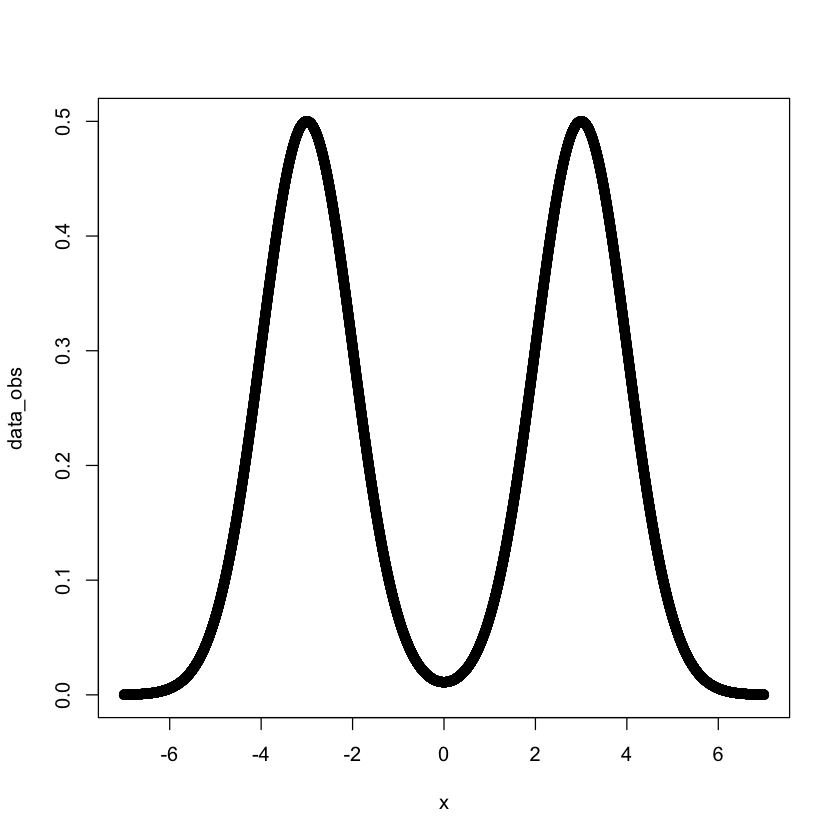

In [4]:
plot(x,data_obs)

In [5]:
# func : a function whose first argument is a real vector of parameters
# func returns a log10 of the likelihood function
# theta.init : the initial value of the Markov Chain (and of func)
# n.sample: number of required samples 
# sigma : standar deviation of the gaussian MCMC sampling pdf

metropolis.1dim <- function(func, theta.init, n.sample , sigma) {

    theta.cur <- theta.init
    func.Cur <- func(theta.cur)

    func.Samp <- matrix(data=NA, nrow=n.sample , ncol=2+1)

    n.accept <- 0 
    rate.accept <- 0.0

    for (n in 1:n.sample) {

        theta.prop <- rnorm(n=1, mean = theta.cur, sigma) 
        func.Prop <- func(theta.prop)
        logMR <- func.Prop - func.Cur # Log10 of the Metropolis ratio

        if ( logMR >=0 || logMR>log10(runif(1)) ) { 
            theta.cur <- theta.prop 
            func.Cur <- func.Prop
            n.accept <- n.accept + 1 
        } 
        
        func.Samp[n, 1] <- func.Cur 
        func.Samp[n, 2] <- theta.cur

    } 
    
    return(func.Samp)
    
}



# - interface for the metropolis function , gets the log10 of test function
testfunc.metropolis <- function(theta) {
    return(log10(g(theta))) }


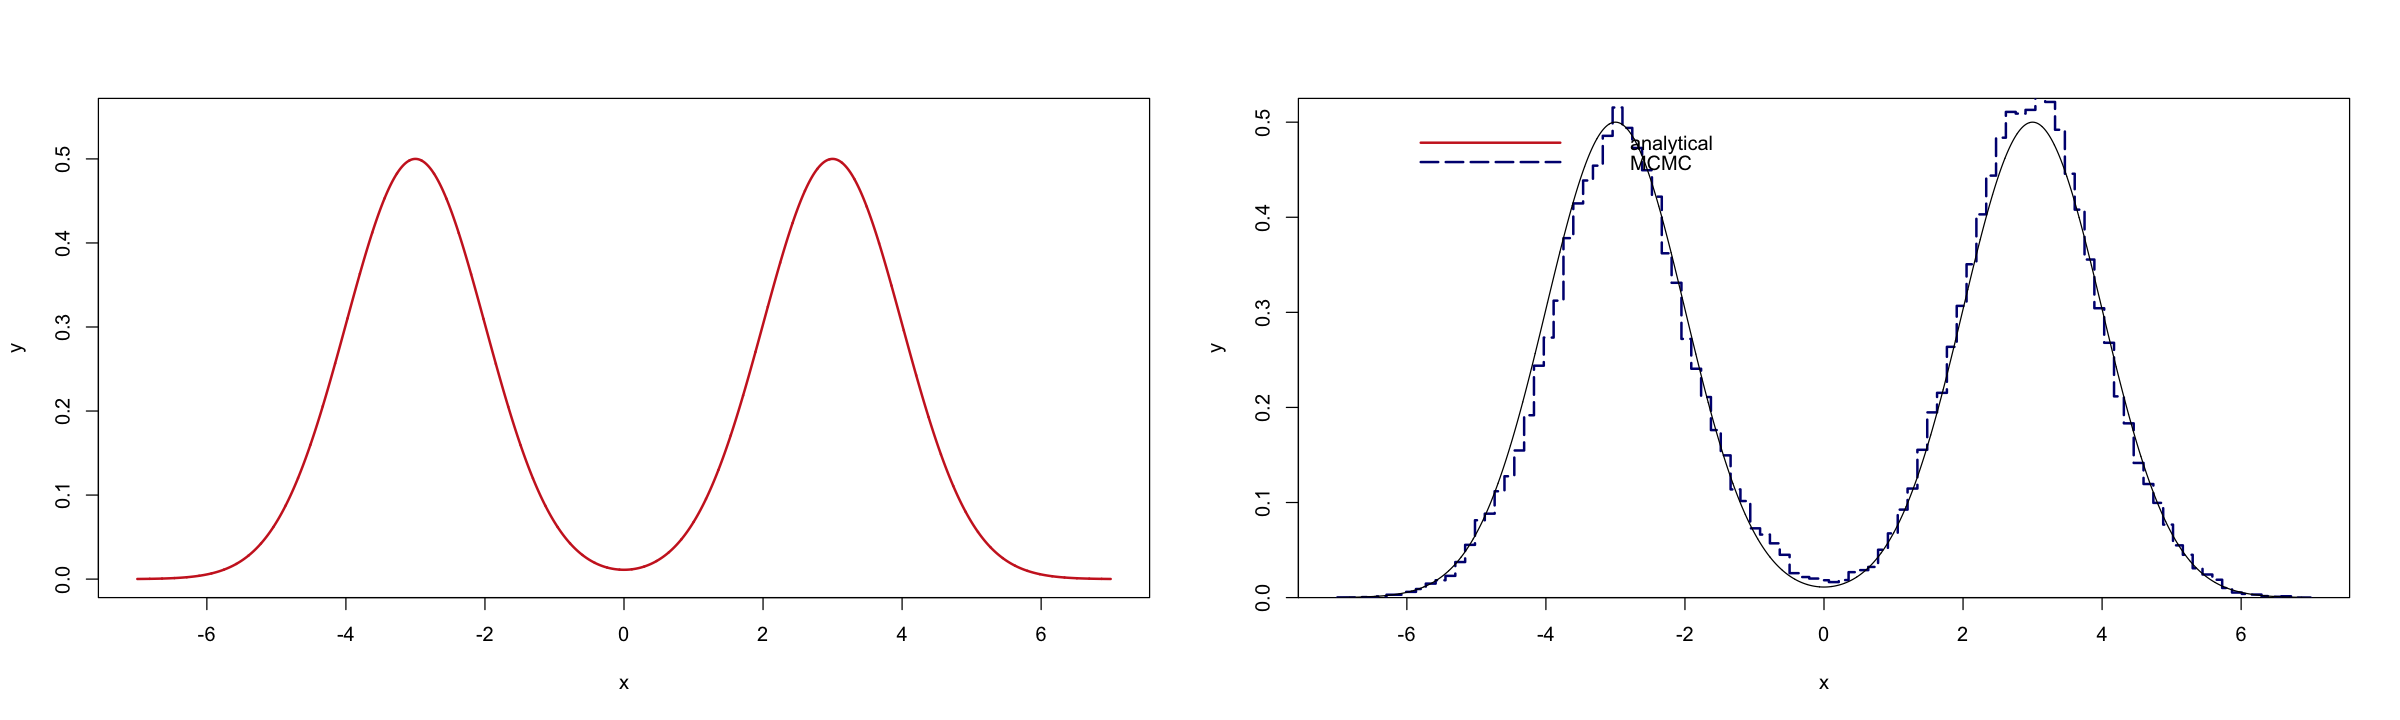

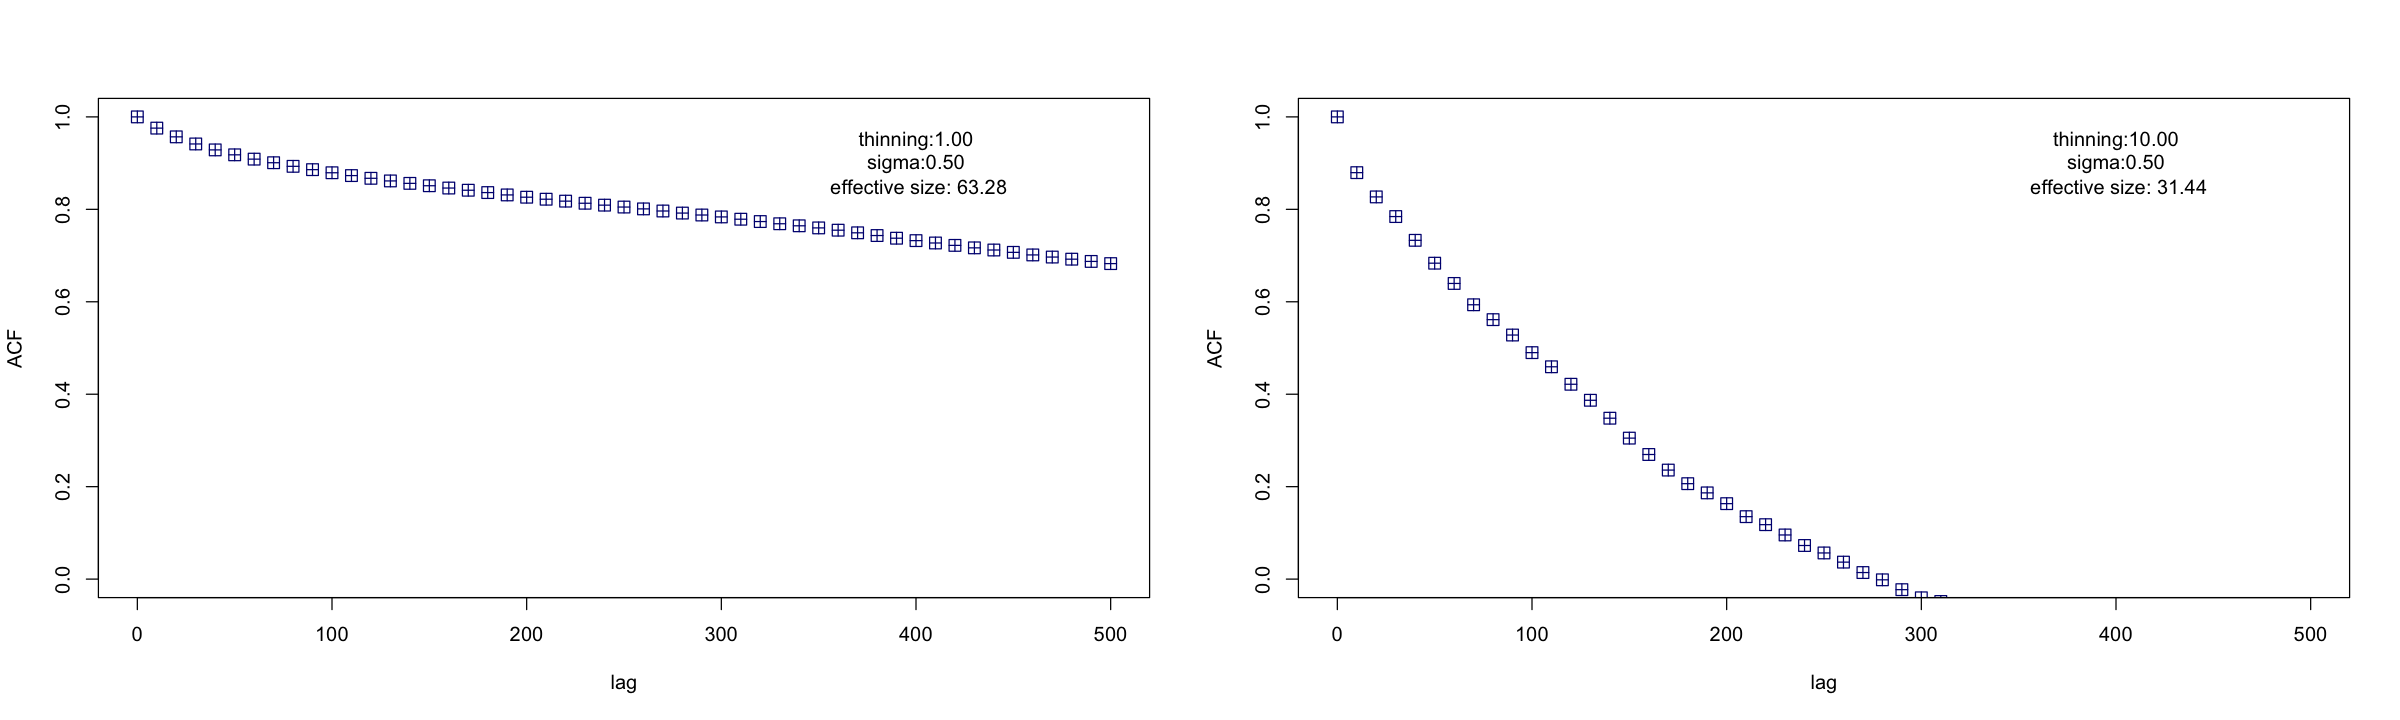

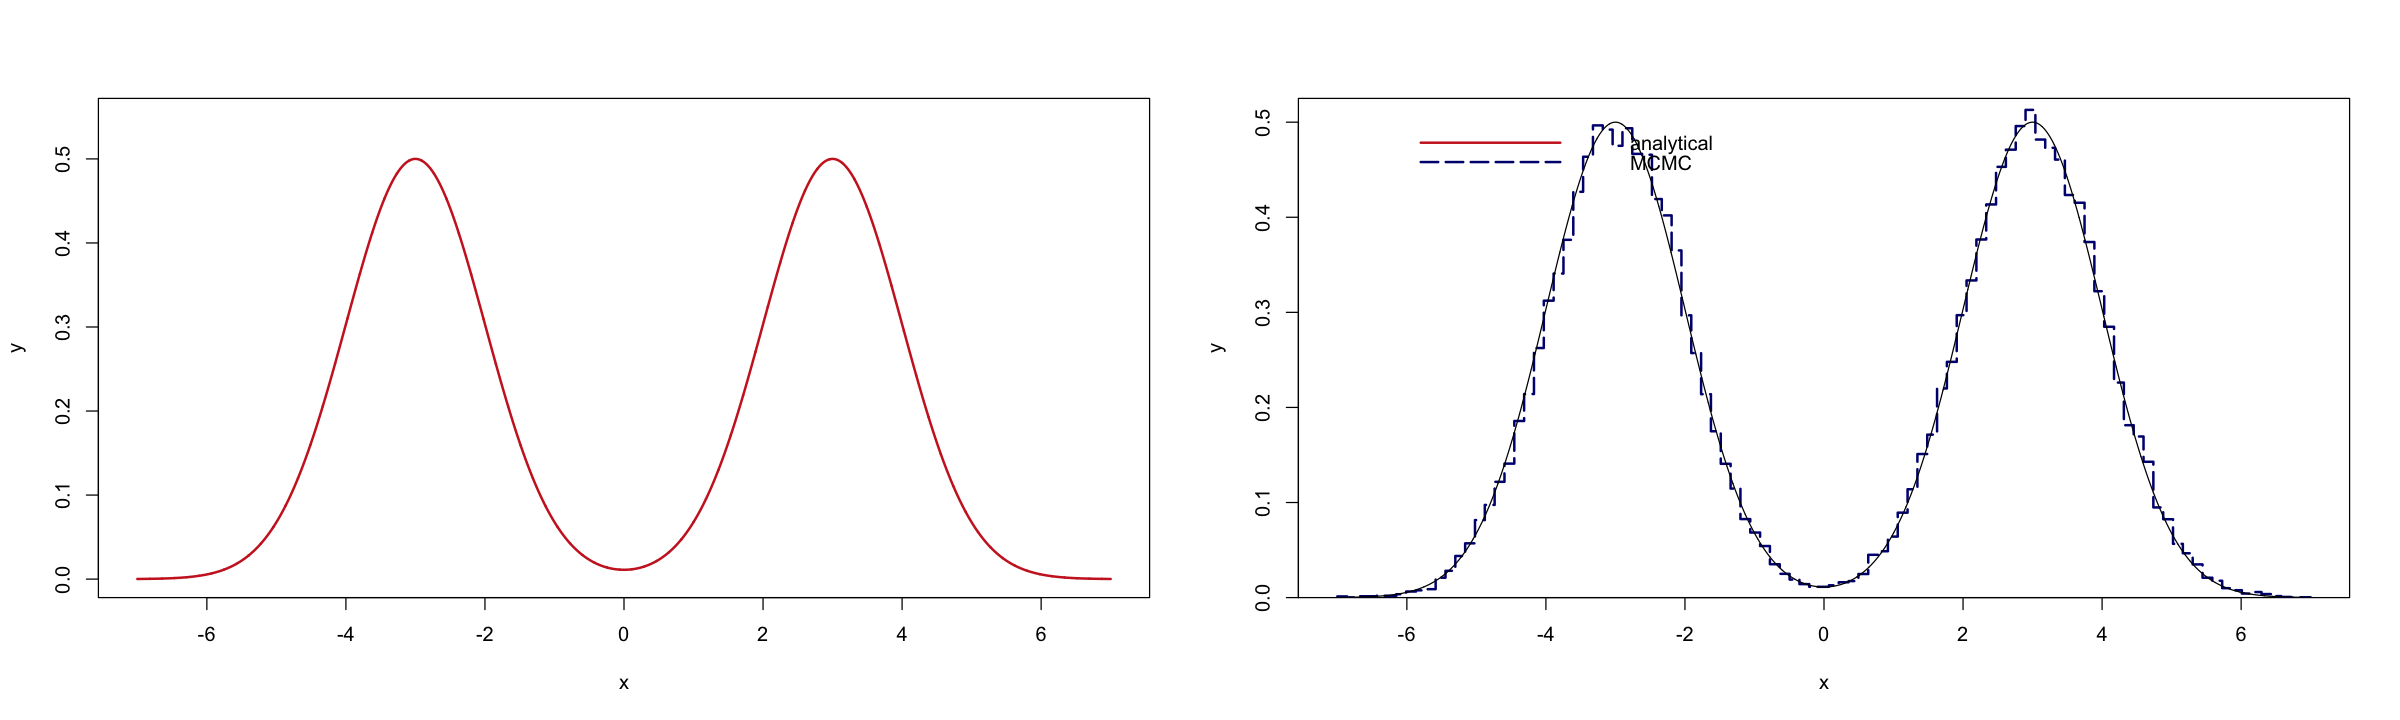

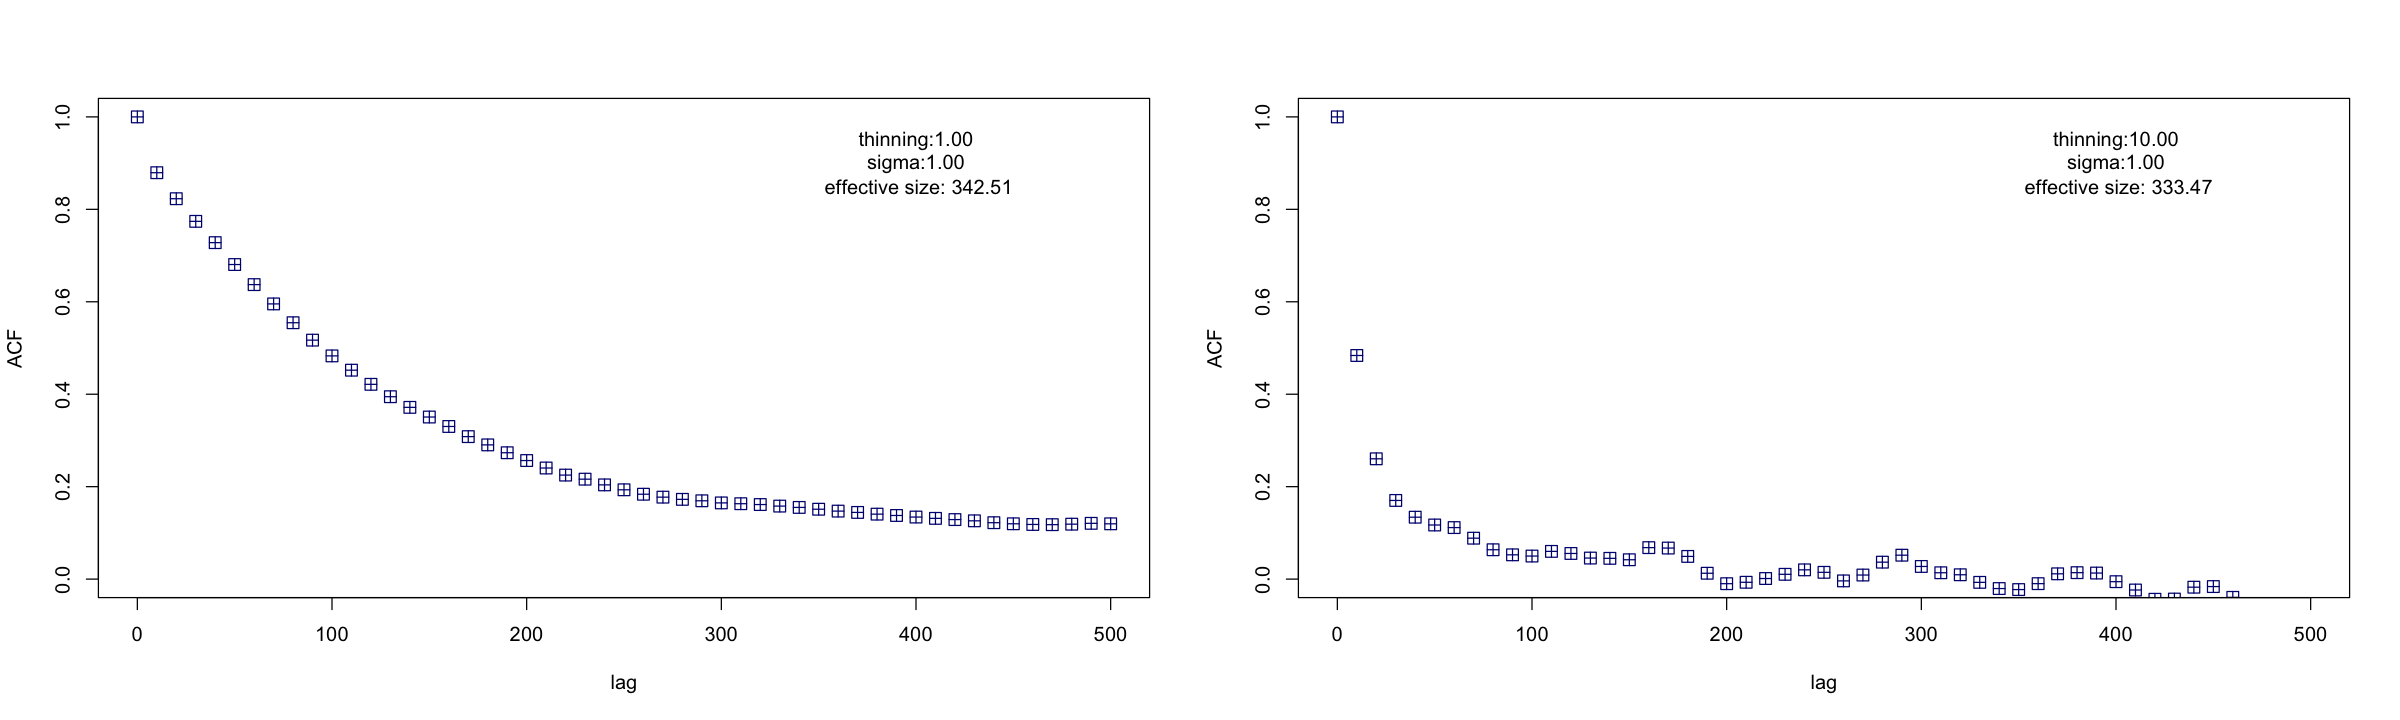

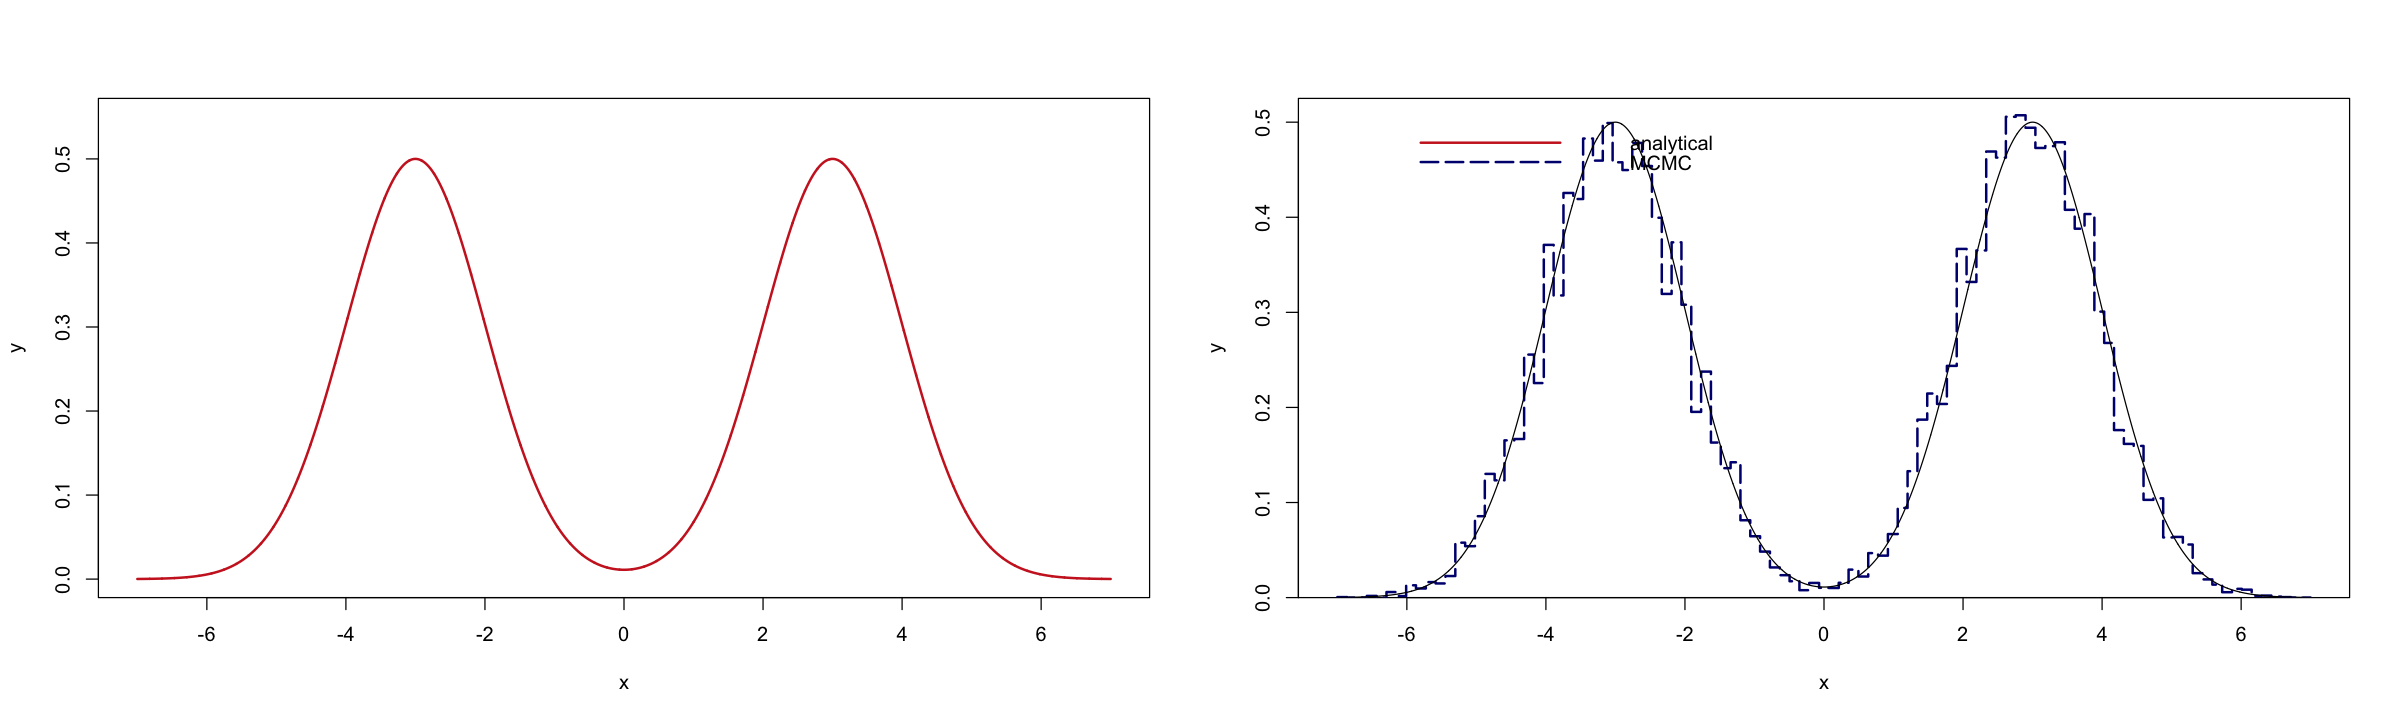

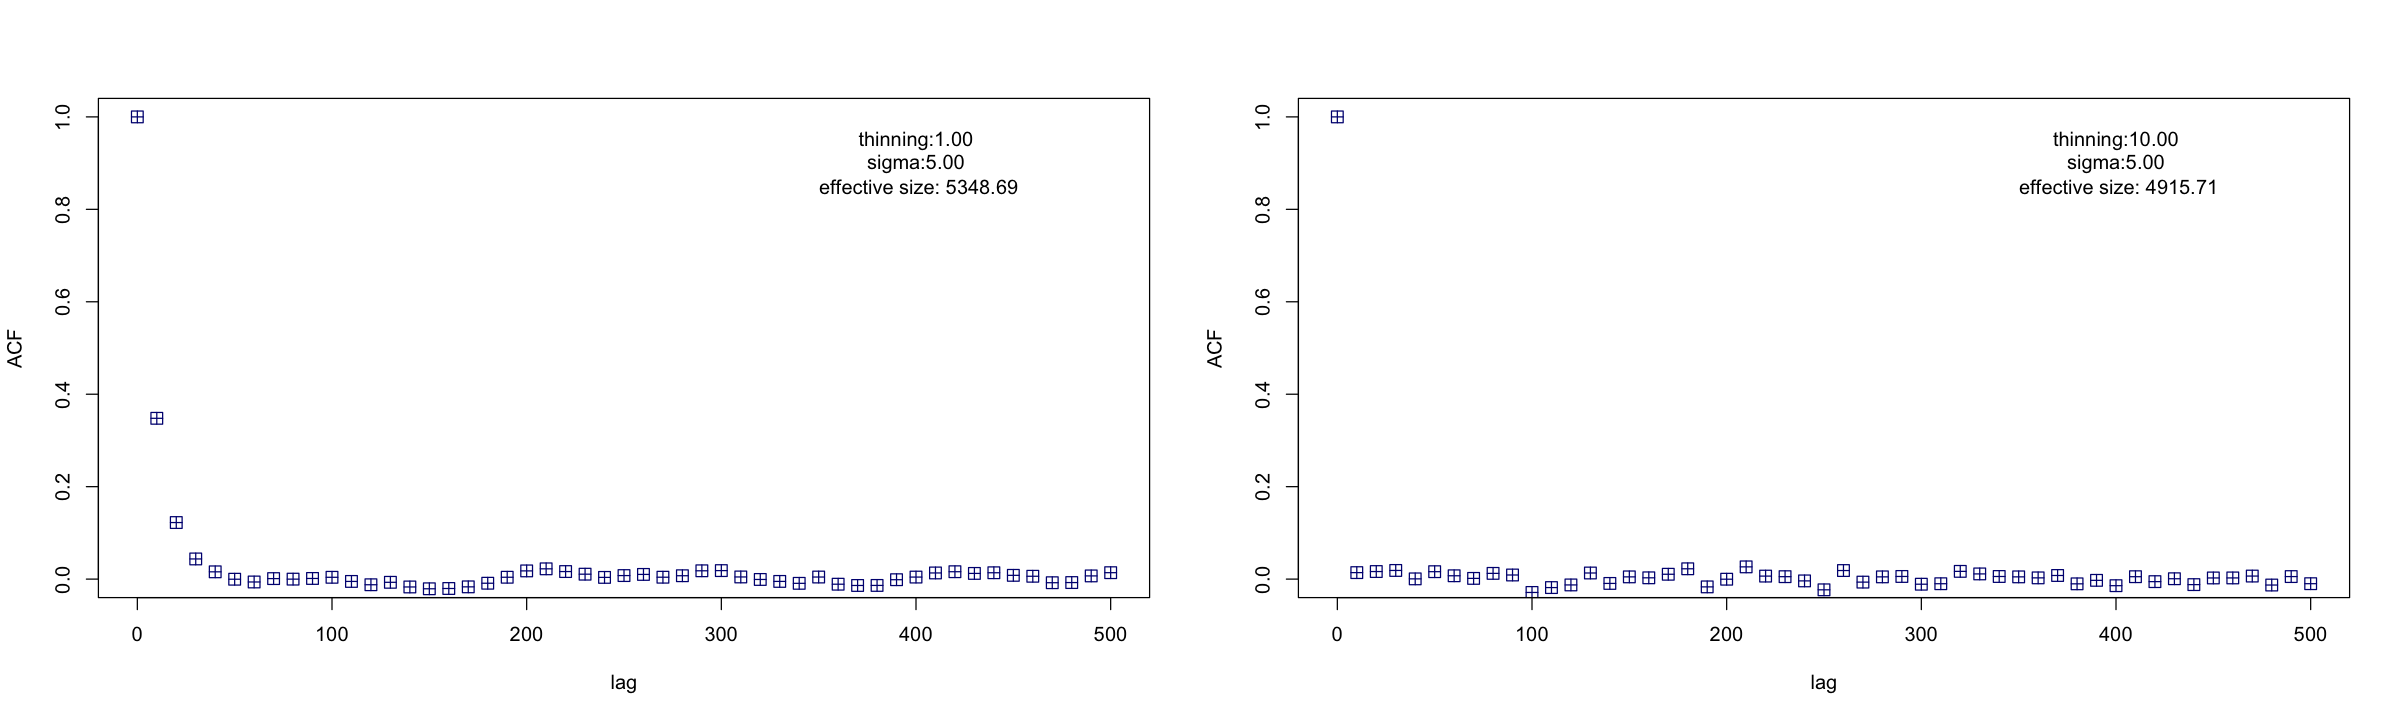

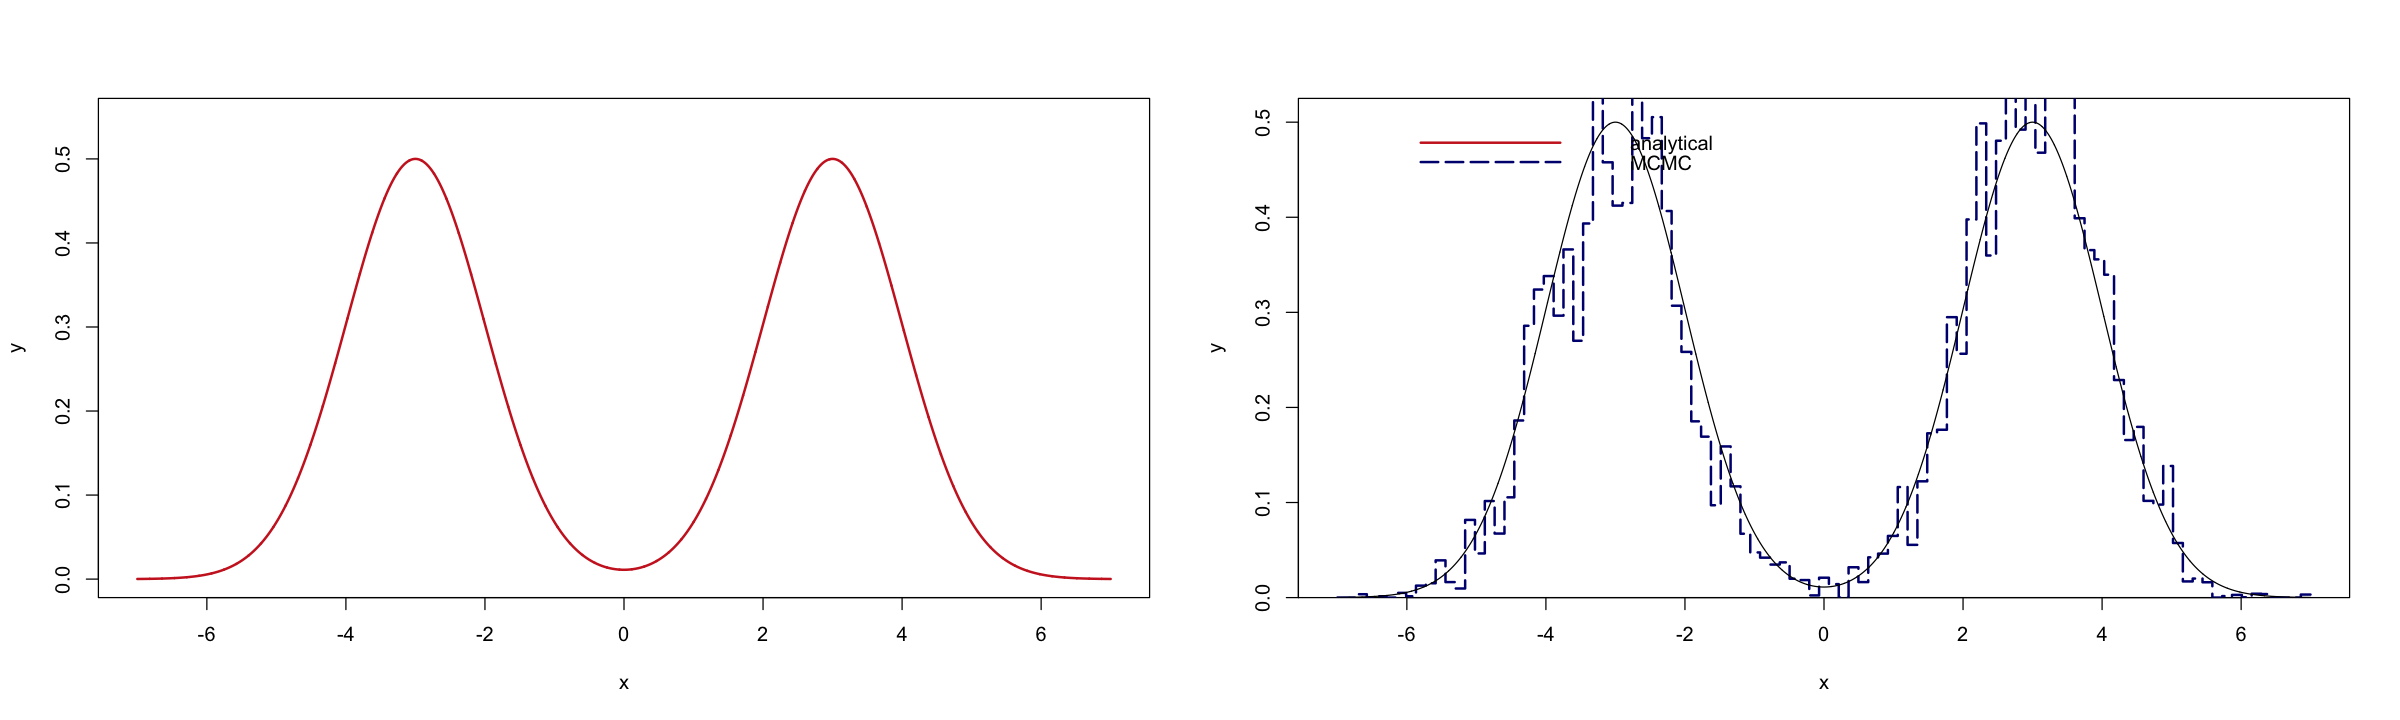

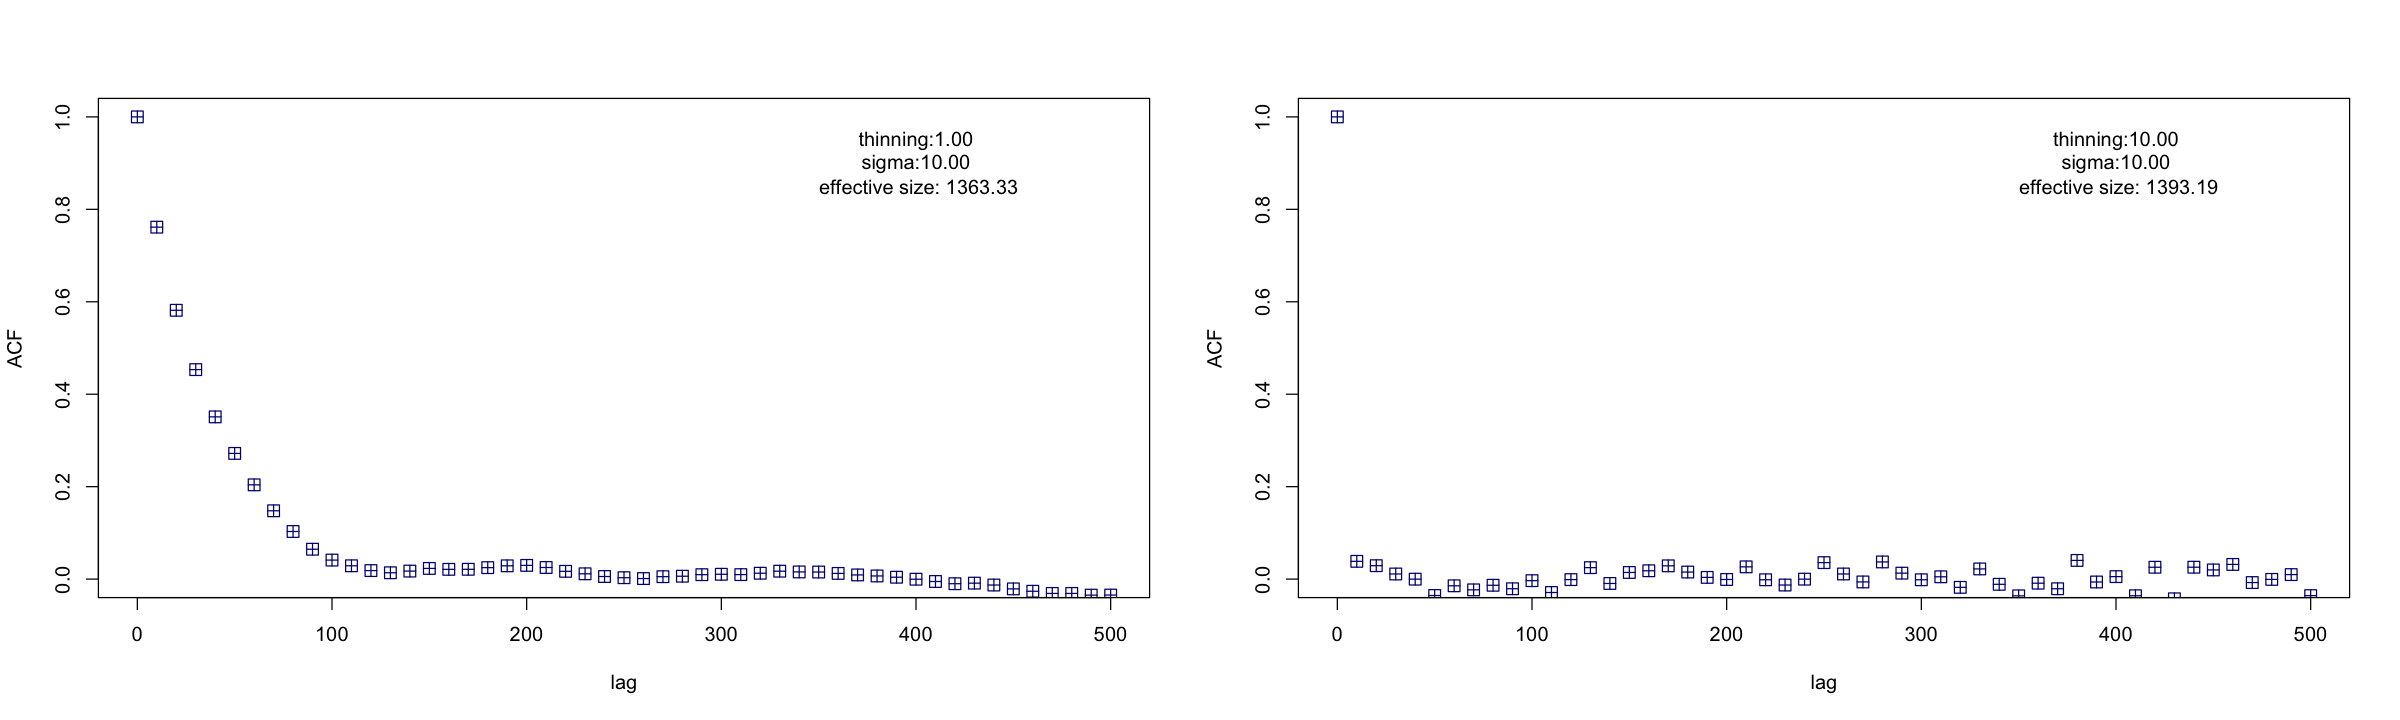

In [6]:
options(repr.plot.width=20, repr.plot.height=6)


sigma<-c(0.5,1,5,10)

for (i in 1:length(sigma)){

### Running parameters
theta.init <- 3
sample.sig <- sigma[i]
n.sample <- 10**5 


chain <- metropolis.1dim(func=testfunc.metropolis ,
                         theta.init = theta.init, n.sample = n.sample ,
                         sigma = sample.sig**2)

par(mfrow=c(1,2))

x <- seq(-7, 7, length.out=10**4)
y <- g(x) 
ymax <- 1.05 * max(y) 

# Compute normalization function: used later to put on same as histogram
Zfunc <- sum(y)*diff(range(x))/(length(x))

plot(x, y, ylim=c(0,max(y)*1.10), type='l', lwd=2, col='firebrick3')

plot(x, y, type="n" , yaxs="i" , ylim=c(0,1.05*max(y)))

sa <- which(chain[,2]>=min(x) & chain[,2]<=max(x))

hist <- hist(chain[sa,2], breaks=seq(from=min(x), to=max(x),length.out=100), plot=FALSE)
Zhist <- sum(hist$counts)*diff(range(hist$breaks))/(length(hist$counts)) 
lines(hist$breaks , c(hist$counts*Zfunc/Zhist,0), col='navy', type="s" , lwd=2, lty=5)

lines(x, y, lwd=1, lty=1)

leg.labels = c('analytical', 'MCMC') 
leg.ltype = c(1, 5)
leg.colors = c('firebrick3','navy') 
legend("topleft" , inset=.05, bty='n', legend = leg.labels, lty=leg.ltype, col=leg.colors,lwd = 2)


c.chain1 <- as.mcmc(chain[,2])

my.lags = seq(0,500,10)

y1 <- autocorr(c.chain1, lags=my.lags)

thin<-1
plot(my.lags, y1, ylim=c(0,1), pch=12, col='navy', xlab='lag', ylab='ACF', cex=1.3) 
text(400,0.9, sprintf('sigma:%.2f',sample.sig)) 
text(400,0.85,sprintf(" effective size: %.2f" , effectiveSize(c.chain1)))
text(400,0.95, sprintf('thinning:%.2f',thin)) 


allSamp<-chain
thin<-10
thinSel <- seq(from=1, to=nrow(allSamp), by=thin) # thin by factor 25

postSamp <- allSamp[thinSel ,]

c.chain1 <- as.mcmc(postSamp[,2])

my.lags = seq(0,500,10)

y1 <- autocorr(c.chain1, lags=my.lags)

plot(my.lags, y1, ylim=c(0,1), pch=12, col='navy', xlab='lag', ylab='ACF', cex=1.3) 
text(400,0.9, sprintf('sigma:%.2f',sample.sig)) 
text(400,0.85,sprintf(" effective size: %.2f" , effectiveSize(c.chain1)))
text(400,0.95, sprintf('thinning:%.2f',thin)) 

}

# 2)

In [107]:
#janssen and Jcovden -> same vaccines

tot_vaccine <- 19630
tot_placebo <- 19691 

patient <- c(rep(" Vaccine" , tot_vaccine), rep(" Placebo" , tot_placebo))

# Number of patients tested postive after RCT: 

pos_vaccine <- 116 
pos_placebo <- 348
tested <- c(rep(" Pos" , pos_vaccine), 
            rep(" Neg" , tot_vaccine - pos_vaccine), 
            rep(" Pos" , pos_placebo), 
            rep(" Neg" , tot_placebo - pos_placebo))

janssen.tb <- tibble(tested = tested, patient=patient) 



table(janssen.tb[[2]], janssen.tb[[1]])
head(janssen.tb)

          
             Neg   Pos
   Placebo 19343   348
   Vaccine 19514   116

tested,patient
<chr>,<chr>
Pos,Vaccine
Pos,Vaccine
Pos,Vaccine
Pos,Vaccine
Pos,Vaccine
Pos,Vaccine


In [108]:
dataList = list(tested = ifelse(janssen.tb$tested == " Neg" , 0, 1), 
                patient = as.integer(factor(janssen.tb$patient)),
                Ntot = nrow(janssen.tb) , 
                Nclass = nlevels(factor(janssen.tb$patient))

)



#model
model_bugs <- "model{

for ( i in 1:Ntot ){
    tested[i] ~ dbern( theta[patient[i]] ) 
} 

for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100) } }"







jm <- jags.model(textConnection(model_bugs), data=dataList)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39321
   Unobserved stochastic nodes: 2
   Total graph size: 78648

Initializing model



In [109]:
# Update the Markov chain (Burn -in)
update (jm , 10000)
chain <- coda.samples(jm , c("theta"), n.iter=10000)
summary(chain)


Iterations = 10001:20000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

             Mean        SD  Naive SE Time-series SE
theta[1] 0.017744 0.0009314 9.314e-06      9.314e-06
theta[2] 0.006034 0.0005521 5.521e-06      5.521e-06

2. Quantiles for each variable:

            2.5%      25%      50%      75%    97.5%
theta[1] 0.01594 0.017119 0.017735 0.018366 0.019589
theta[2] 0.00500 0.005656 0.006016 0.006401 0.007173


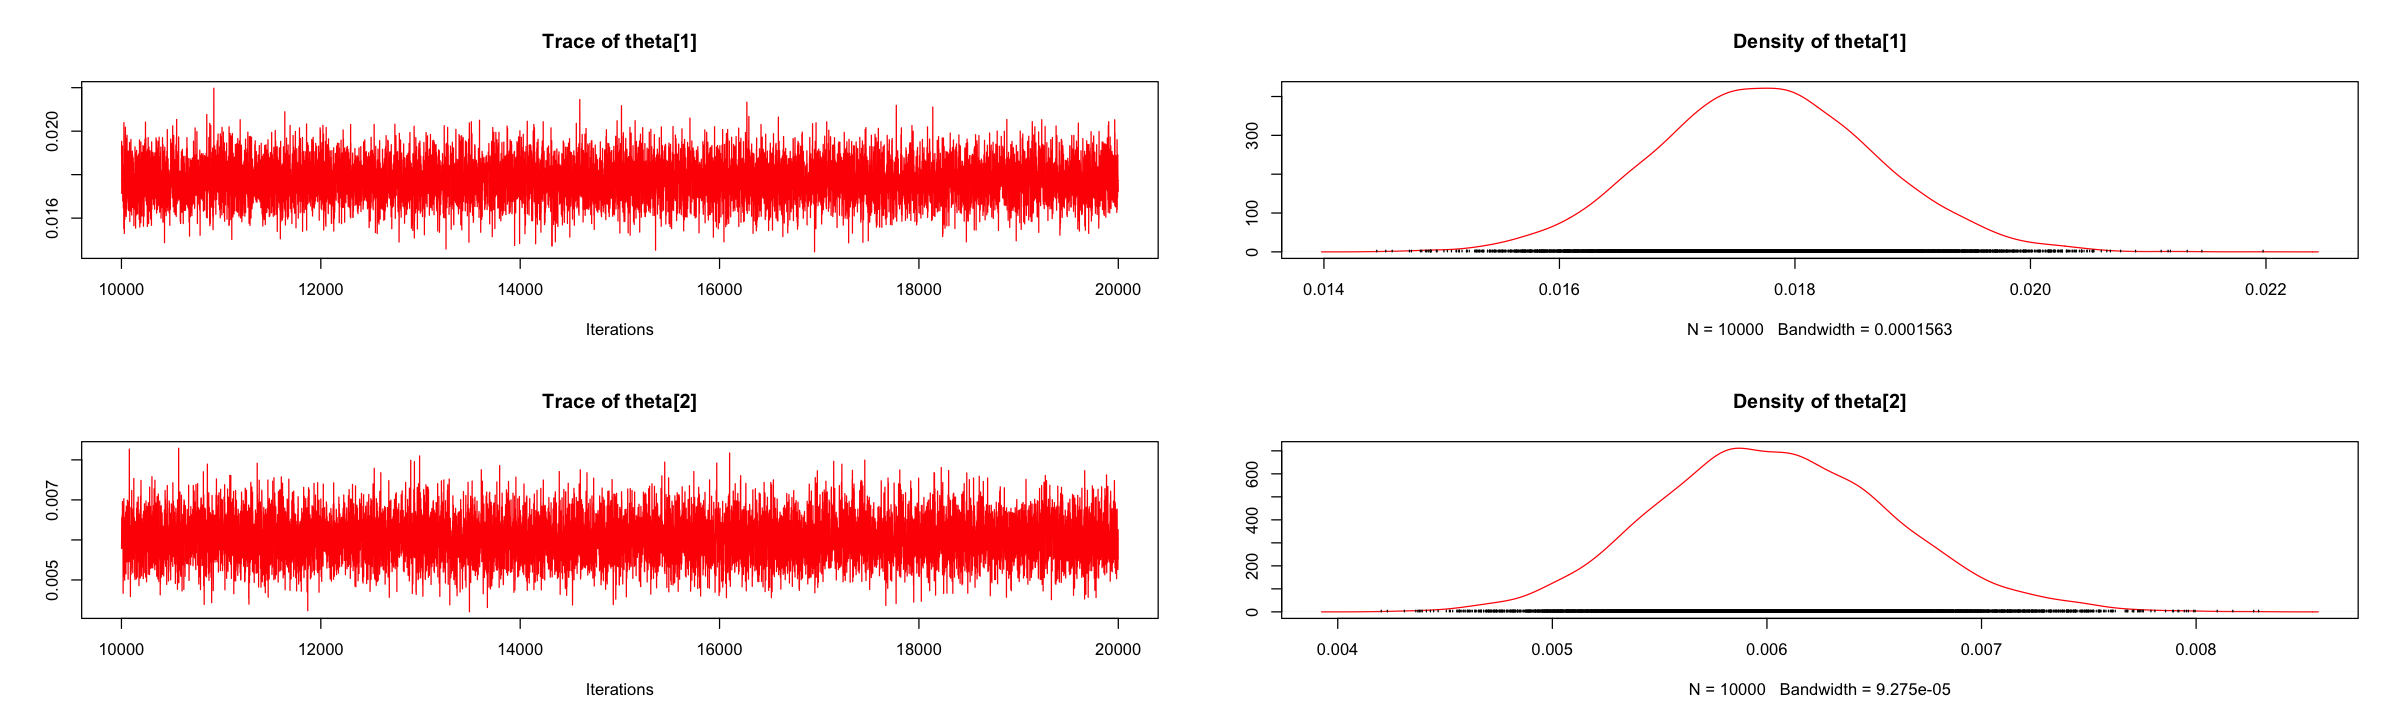

In [110]:
plot(chain, col="red")

# A tibble: 1 × 4
  variable  mean `2.5%` `97.5%`
  <chr>    <num>  <num>   <num>
1 value     65.9   58.3    72.7


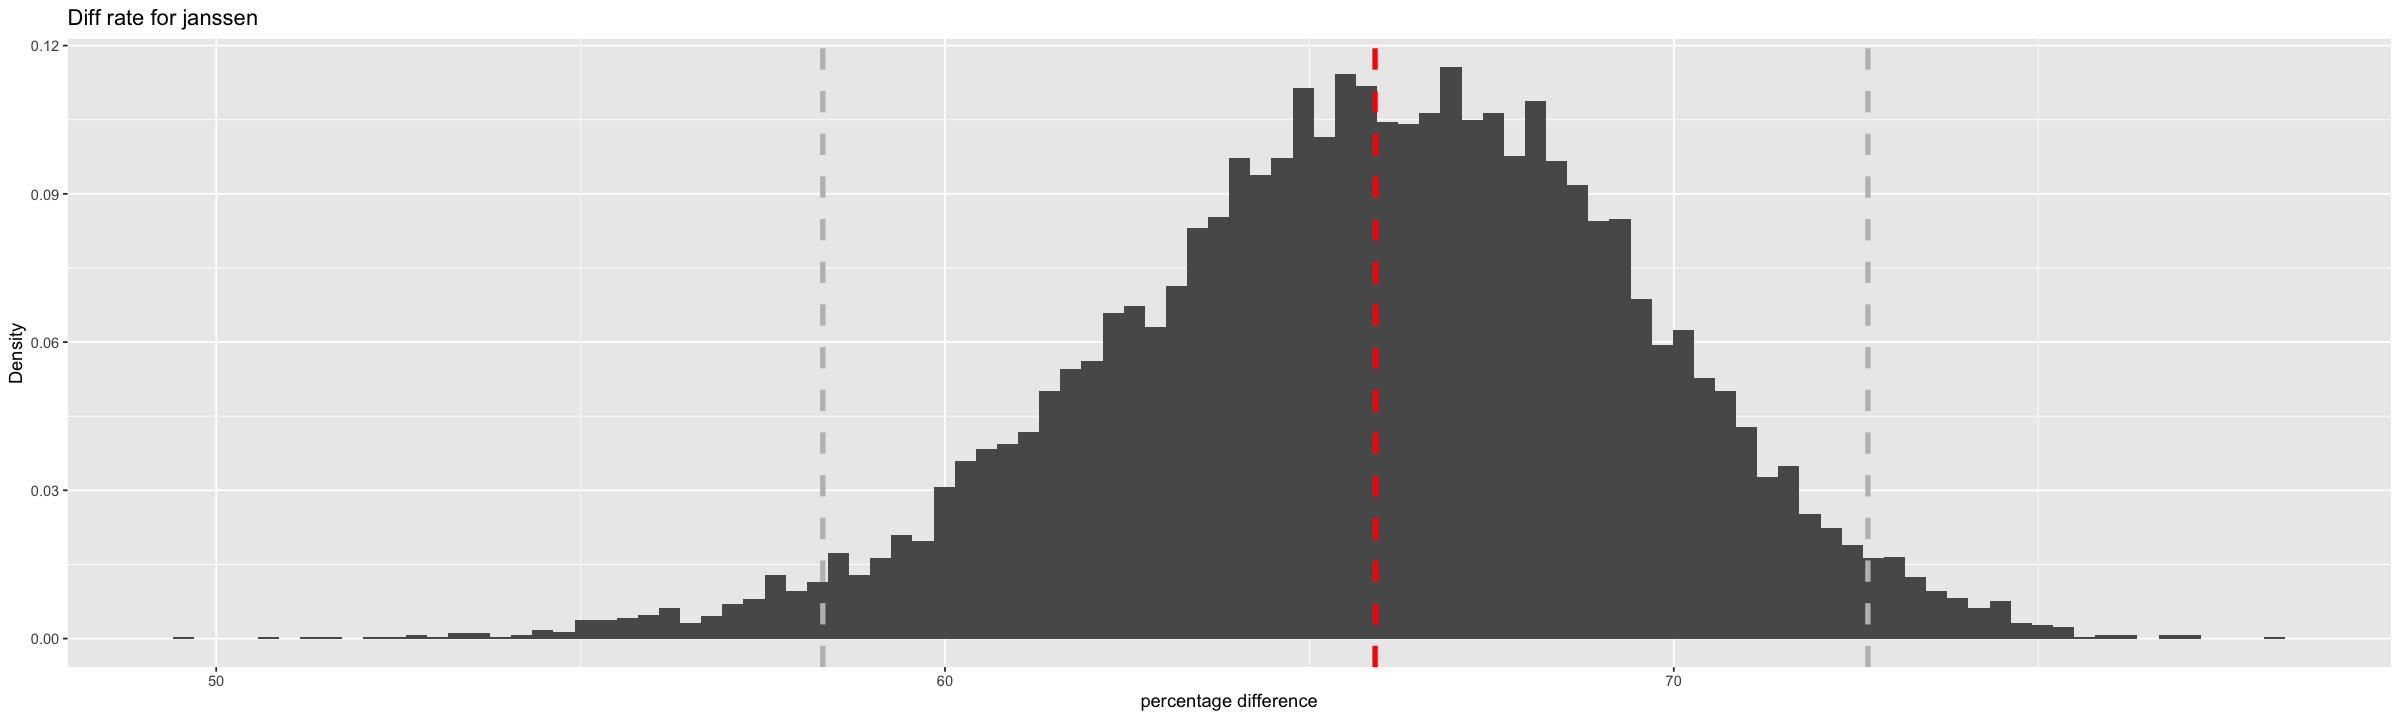

In [111]:
janssen_res<- tidybayes::tidy_draws(chain) %>% 
                select('theta[1]':'theta[2]') %>%
                rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                    Placebo_perc = Placebo * 100, Vaccine_perc = Vaccine * 100)

allmcmc2 <- as.mcmc(janssen_res, vars="diff_rate" )

df<-as.data.frame(allmcmc2)

rates<-as_tibble(janssen_res$diff_rate)

ci<-summarise_draws(rates, mean,~quantile(.x,probs = c(0.025, 0.975)))

print(ci)

a <- ggplot() +
  geom_histogram(aes(df$diff_rate, y=after_stat(density)), bins=100)  + 
              geom_vline(xintercept =ci[[3]],linetype='dashed', color='grey',linewidth=1.5)+
               geom_vline(xintercept =ci[[4]],linetype='dashed',color='grey',linewidth=1.5)+
                geom_vline(xintercept =ci[[2]],linetype='dashed',color='red',linewidth=1.5)+

        labs(title='Diff rate for janssen', x='percentage difference',
                                y='Density') 
a


In [103]:
#Spikevax

tot_vaccine <- 14134
tot_placebo <- 14073 

patient <- c(rep(" Vaccine" , tot_vaccine), rep(" Placebo" , tot_placebo))

# Number of patients tested postive after RCT: 

pos_vaccine <- 11 
pos_placebo <- 185
tested <- c(rep(" Pos" , pos_vaccine), 
            rep(" Neg" , tot_vaccine - pos_vaccine), 
            rep(" Pos" , pos_placebo), 
            rep(" Neg" , tot_placebo - pos_placebo))

spikevax.tb <- tibble(tested = tested, patient=patient) 



table(spikevax.tb[[2]], spikevax.tb[[1]])
head(spikevax.tb)

          
             Neg   Pos
   Placebo 13888   185
   Vaccine 14123    11

tested,patient
<chr>,<chr>
Pos,Vaccine
Pos,Vaccine
Pos,Vaccine
Pos,Vaccine
Pos,Vaccine
Pos,Vaccine


In [104]:
dataList = list(tested = ifelse(spikevax.tb$tested == " Neg" , 0, 1), 
                patient = as.integer(factor(spikevax.tb$patient)),
                Ntot = nrow(spikevax.tb) , 
                Nclass = nlevels(factor(spikevax.tb$patient))

)

#model
model_bugs <- "model{

for ( i in 1:Ntot ){
    tested[i] ~ dbern( theta[patient[i]] ) 
} 

for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100) } }"

jm <- jags.model(textConnection(model_bugs), data=dataList)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 56420

Initializing model




Iterations = 10001:20000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean        SD  Naive SE Time-series SE
theta[1] 0.0132698 0.0009578 9.578e-06      9.435e-06
theta[2] 0.0009881 0.0002653 2.653e-06      2.653e-06

2. Quantiles for each variable:

              2.5%     25%       50%     75%    97.5%
theta[1] 0.0114572 0.01261 0.0132538 0.01391 0.015202
theta[2] 0.0005394 0.00080 0.0009665 0.00115 0.001576


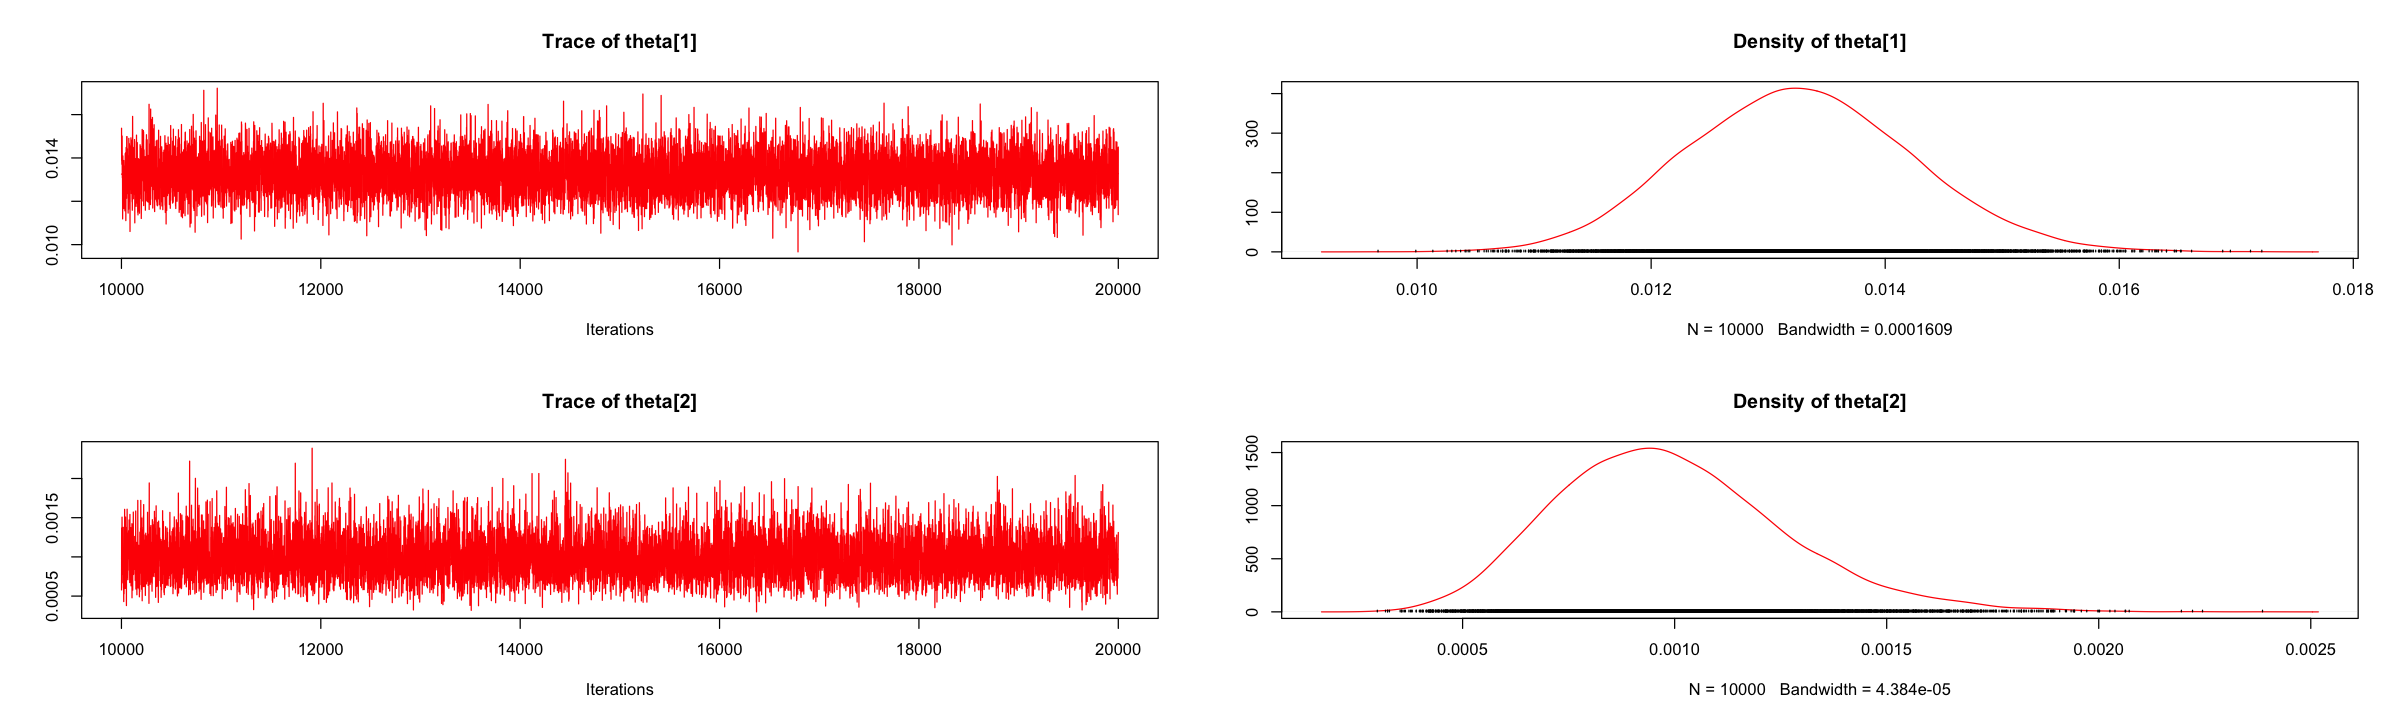

In [105]:
# Update the Markov chain (Burn -in)
update (jm , 10000)
chain <- coda.samples(jm , c("theta"), n.iter=10000)
summary(chain)
plot(chain, col="red")

# A tibble: 1 × 4
  variable  mean `2.5%` `97.5%`
  <chr>    <num>  <num>   <num>
1 value     92.5   87.8    96.0


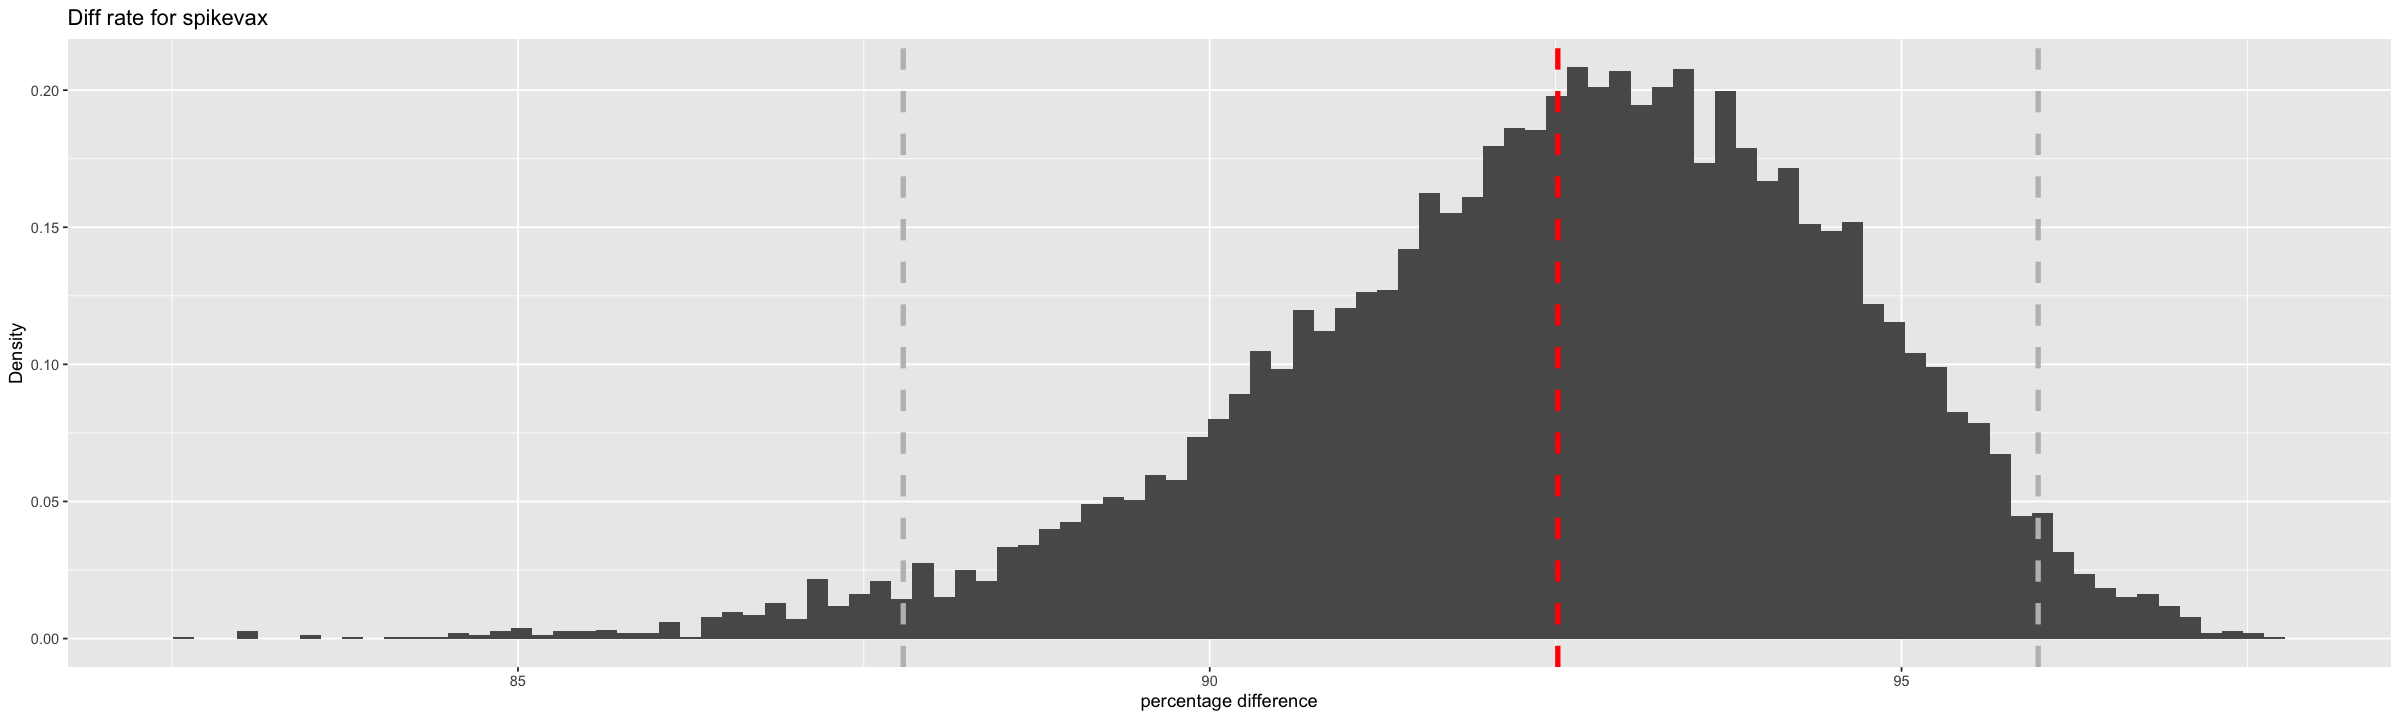

In [106]:
spikevax_res<- tidybayes::tidy_draws(chain) %>% 
                select('theta[1]':'theta[2]') %>%
                rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                    Placebo_perc = Placebo * 100, Vaccine_perc = Vaccine * 100)

allmcmc2 <- as.mcmc(spikevax_res, vars="diff_rate" )

df<-as.data.frame(allmcmc2)

rates<-as_tibble(spikevax_res$diff_rate)

ci<-summarise_draws(rates, mean,~quantile(.x,probs = c(0.025, 0.975)))

print(ci)

a <- ggplot() +
  geom_histogram(aes(df$diff_rate, y=after_stat(density)), bins=100)  + 
              geom_vline(xintercept =ci[[3]],linetype='dashed', color='grey',linewidth=1.5)+
               geom_vline(xintercept =ci[[4]],linetype='dashed',color='grey',linewidth=1.5)+
                geom_vline(xintercept =ci[[2]],linetype='dashed',color='red',linewidth=1.5)+

        labs(title='Diff rate for spikevax', x='percentage difference',
                                y='Density') 
a


In [95]:
#astrazeneca
tot_vaccine <- 5258
tot_placebo <- 5210

patient <- c(rep(" Vaccine" , tot_vaccine), rep(" Placebo" , tot_placebo))

# Number of patients tested postive after RCT: 

pos_vaccine <- 64
pos_placebo <- 154
tested <- c(rep(" Pos" , pos_vaccine), 
            rep(" Neg" , tot_vaccine - pos_vaccine), 
            rep(" Pos" , pos_placebo), 
            rep(" Neg" , tot_placebo - pos_placebo))

astrazeneca.tb <- tibble(tested = tested, patient=patient) 



table(astrazeneca.tb[[2]], astrazeneca.tb[[1]])
head(astrazeneca.tb)

          
            Neg  Pos
   Placebo 5056  154
   Vaccine 5194   64

tested,patient
<chr>,<chr>
Pos,Vaccine
Pos,Vaccine
Pos,Vaccine
Pos,Vaccine
Pos,Vaccine
Pos,Vaccine


In [96]:
dataList = list(tested = ifelse(astrazeneca.tb$tested == " Neg" , 0, 1), 
                patient = as.integer(factor(astrazeneca.tb$patient)),
                Ntot = nrow(astrazeneca.tb) , 
                Nclass = nlevels(factor(astrazeneca.tb$patient))

)

#model
model_bugs <- "model{

for ( i in 1:Ntot ){
    tested[i] ~ dbern( theta[patient[i]] ) 
} 

for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100) } }"

jm <- jags.model(textConnection(model_bugs), data=dataList)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10468
   Unobserved stochastic nodes: 2
   Total graph size: 20942

Initializing model




Iterations = 10001:20000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean       SD  Naive SE Time-series SE
theta[1] 0.02955 0.002326 2.326e-05      2.326e-05
theta[2] 0.01250 0.001507 1.507e-05      1.464e-05

2. Quantiles for each variable:

             2.5%     25%     50%     75%   97.5%
theta[1] 0.025156 0.02794 0.02950 0.03109 0.03423
theta[2] 0.009735 0.01144 0.01245 0.01350 0.01559


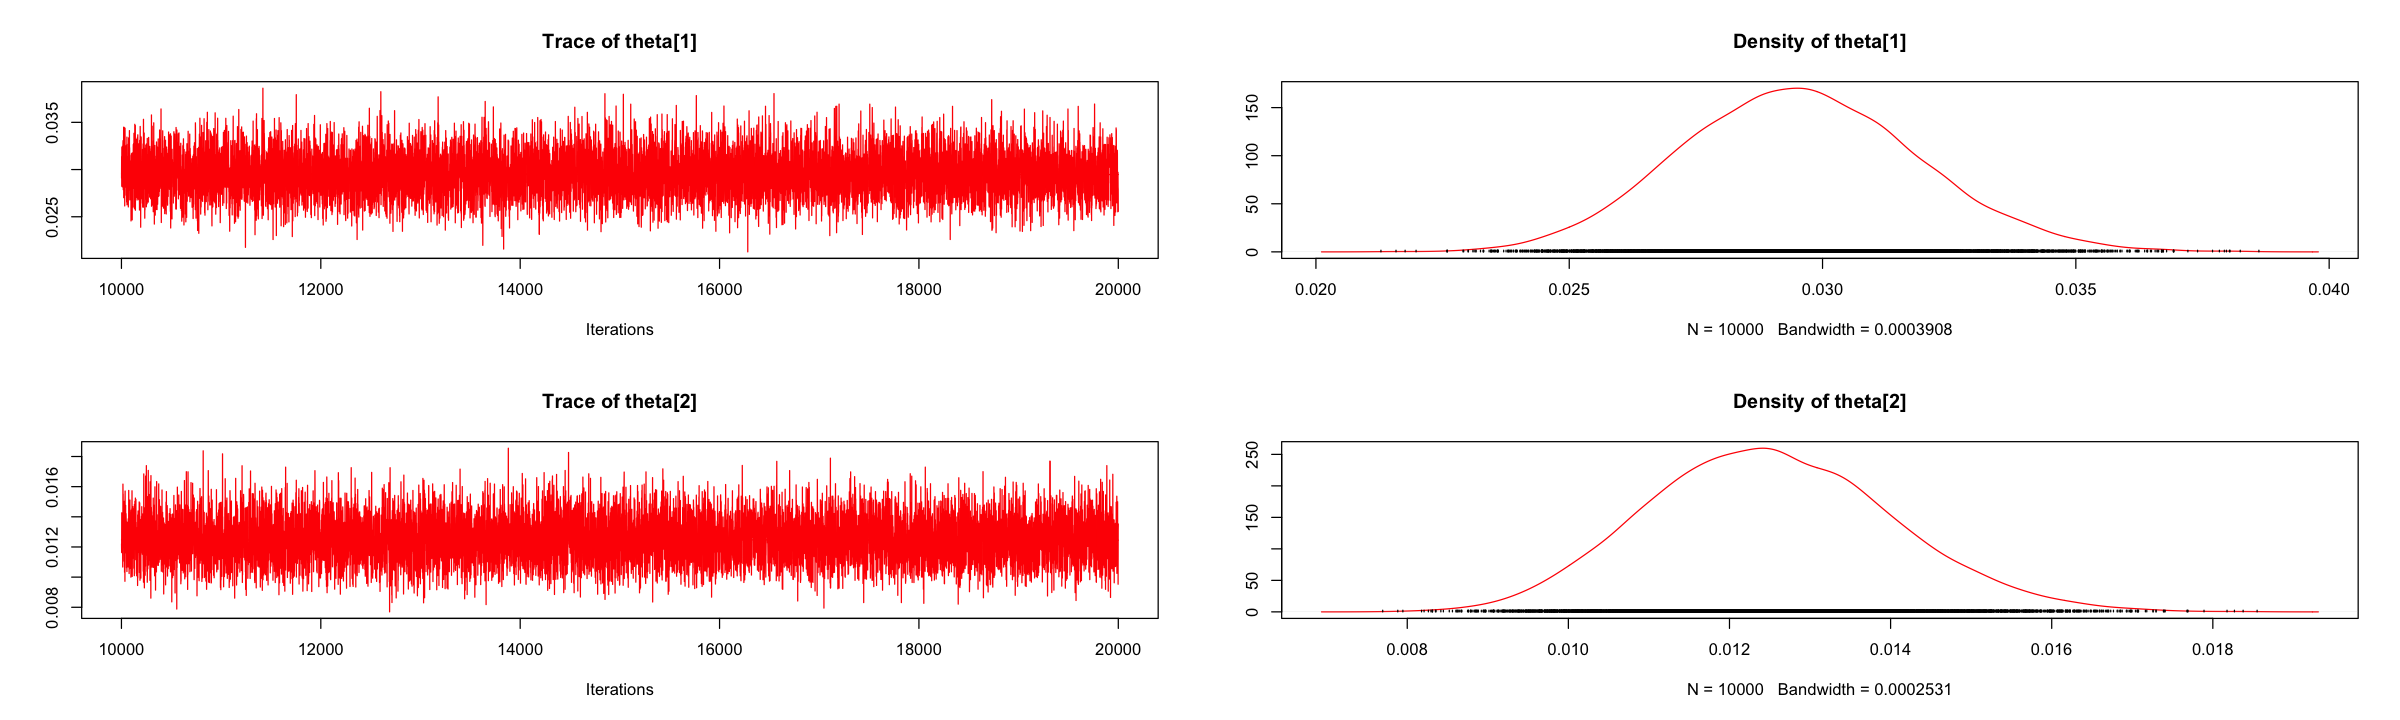

In [97]:
# Update the Markov chain (Burn -in)
update (jm , 10000)
chain <- coda.samples(jm , c("theta"), n.iter=10000)
summary(chain)
plot(chain, col="red")

# A tibble: 1 × 4
  variable  mean `2.5%` `97.5%`
  <chr>    <num>  <num>   <num>
1 value     57.4   44.7    68.3


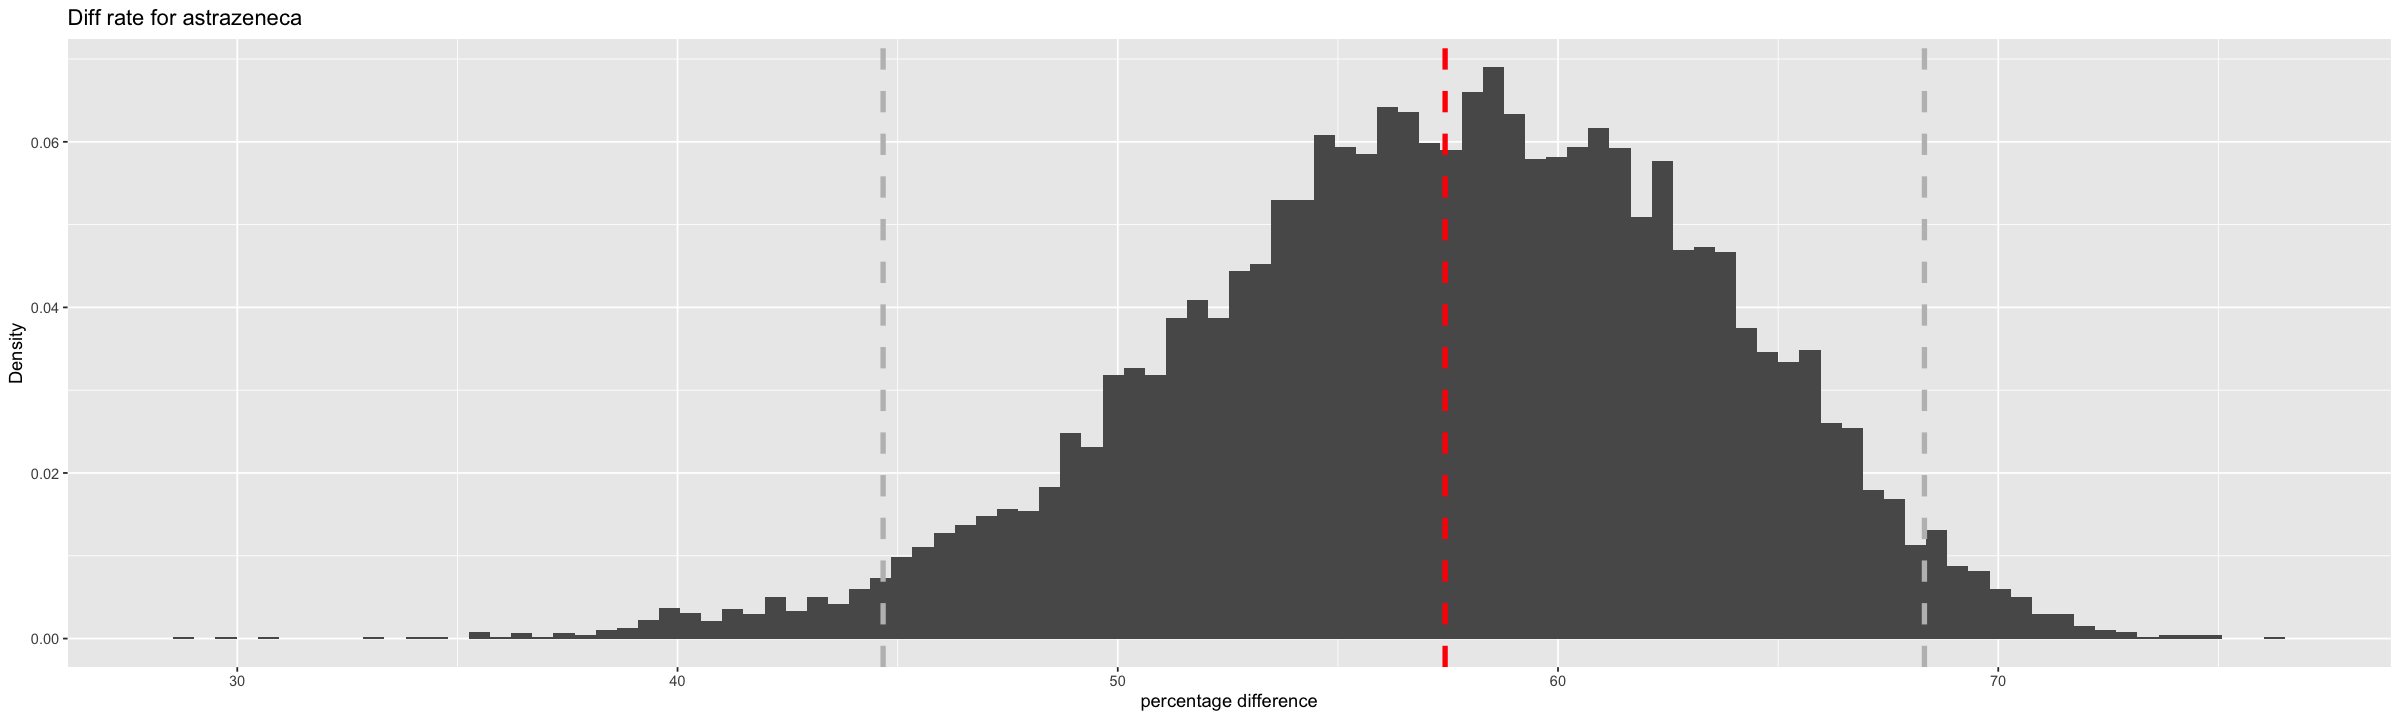

In [102]:
astrazeneca_res<- tidybayes::tidy_draws(chain) %>% 
                select('theta[1]':'theta[2]') %>%
                rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                    Placebo_perc = Placebo * 100, Vaccine_perc = Vaccine * 100)

allmcmc2 <- as.mcmc(astrazeneca_res, vars="diff_rate" )

df<-as.data.frame(allmcmc2)

rates<-as_tibble(astrazeneca_res$diff_rate)

ci<-summarise_draws(rates, mean,~quantile(.x,probs = c(0.025, 0.975)))

print(ci)

a <- ggplot() +
  geom_histogram(aes(df$diff_rate, y=after_stat(density)), bins=100)  + 
              geom_vline(xintercept =ci[[3]],linetype='dashed', color='grey',linewidth=1.5)+
               geom_vline(xintercept =ci[[4]],linetype='dashed',color='grey',linewidth=1.5)+
                geom_vline(xintercept =ci[[2]],linetype='dashed',color='red',linewidth=1.5)+

        labs(title='Diff rate for astrazeneca', x='percentage difference',
                                y='Density') 
a


# 3

In [167]:
covid <- read.delim("owid-covid-data.csv", header = TRUE, sep = ",",)


In [168]:
colnames(covid)

[1] "iso_code"                                  
 [2] "continent"                                 
 [3] "location"                                  
 [4] "date"                                      
 [5] "total_cases"                               
 [6] "new_cases"                                 
 [7] "new_cases_smoothed"                        
 [8] "total_deaths"                              
 [9] "new_deaths"                                
[10] "new_deaths_smoothed"                       
[11] "total_cases_per_million"                   
[12] "new_cases_per_million"                     
[13] "new_cases_smoothed_per_million"            
[14] "total_deaths_per_million"                  
[15] "new_deaths_per_million"                    
[16] "new_deaths_smoothed_per_million"           
[17] "reproduction_rate"                         
[18] "icu_patients"                              
[19] "icu_patients_per_million"                  
[20] "hosp_patients"                             
[21] "hosp_patients_per_million"                 
[22] "weekly_icu_admissions"                     
[23] "weekly_icu_admissions_per_million"         
[24] "weekly_hosp_admissions"                    
[25] "weekly_hosp_admissions_per_million"        
[26] "total_tests"                               
[27] "new_tests"                                 
[28] "total_tests_per_thousand"                  
[29] "new_tests_per_thousand"                    
[30] "new_tests_smoothed"                        
[31] "new_tests_smoothed_per_thousand"           
[32] "positive_rate"                             
[33] "tests_per_case"                            
[34] "tests_units"                               
[35] "total_vaccinations"                        
[36] "people_vaccinated"                         
[37] "people_fully_vaccinated"                   
[38] "total_boosters"                            
[39] "new_vaccinations"                          
[40] "new_vaccinations_smoothed"                 
[41] "total_vaccinations_per_hundred"            
[42] "people_vaccinated_per_hundred"             
[43] "people_fully_vaccinated_per_hundred"       
[44] "total_boosters_per_hundred"                
[45] "new_vaccinations_smoothed_per_million"     
[46] "new_people_vaccinated_smoothed"            
[47] "new_people_vaccinated_smoothed_per_hundred"
[48] "stringency_index"                          
[49] "population_density"                        
[50] "median_age"                                
[51] "aged_65_older"                             
[52] "aged_70_older"                             
[53] "gdp_per_capita"                            
[54] "extreme_poverty"                           
[55] "cardiovasc_death_rate"                     
[56] "diabetes_prevalence"                       
[57] "female_smokers"                            
[58] "male_smokers"                              
[59] "handwashing_facilities"                    
[60] "hospital_beds_per_thousand"                
[61] "life_expectancy"                           
[62] "human_development_index"                   
[63] "population"                                
[64] "excess_mortality_cumulative_absolute"      
[65] "excess_mortality_cumulative"               
[66] "excess_mortality"                          
[67] "excess_mortality_cumulative_per_million"

Columns used:
- new_vaccinations: New COVID-19 vaccination doses administered (only calculated for consecutive days)
- total_vaccinations: Total number of COVID-19 vaccination doses administered
- new_deaths: New deaths attributed to COVID-19. Counts can include probable deaths, where reported. 
- total_deaths: Total deaths attributed to COVID-19. Counts can include probable deaths, where reported.

https://github.com/owid/covid-19-data/tree/master/public/data

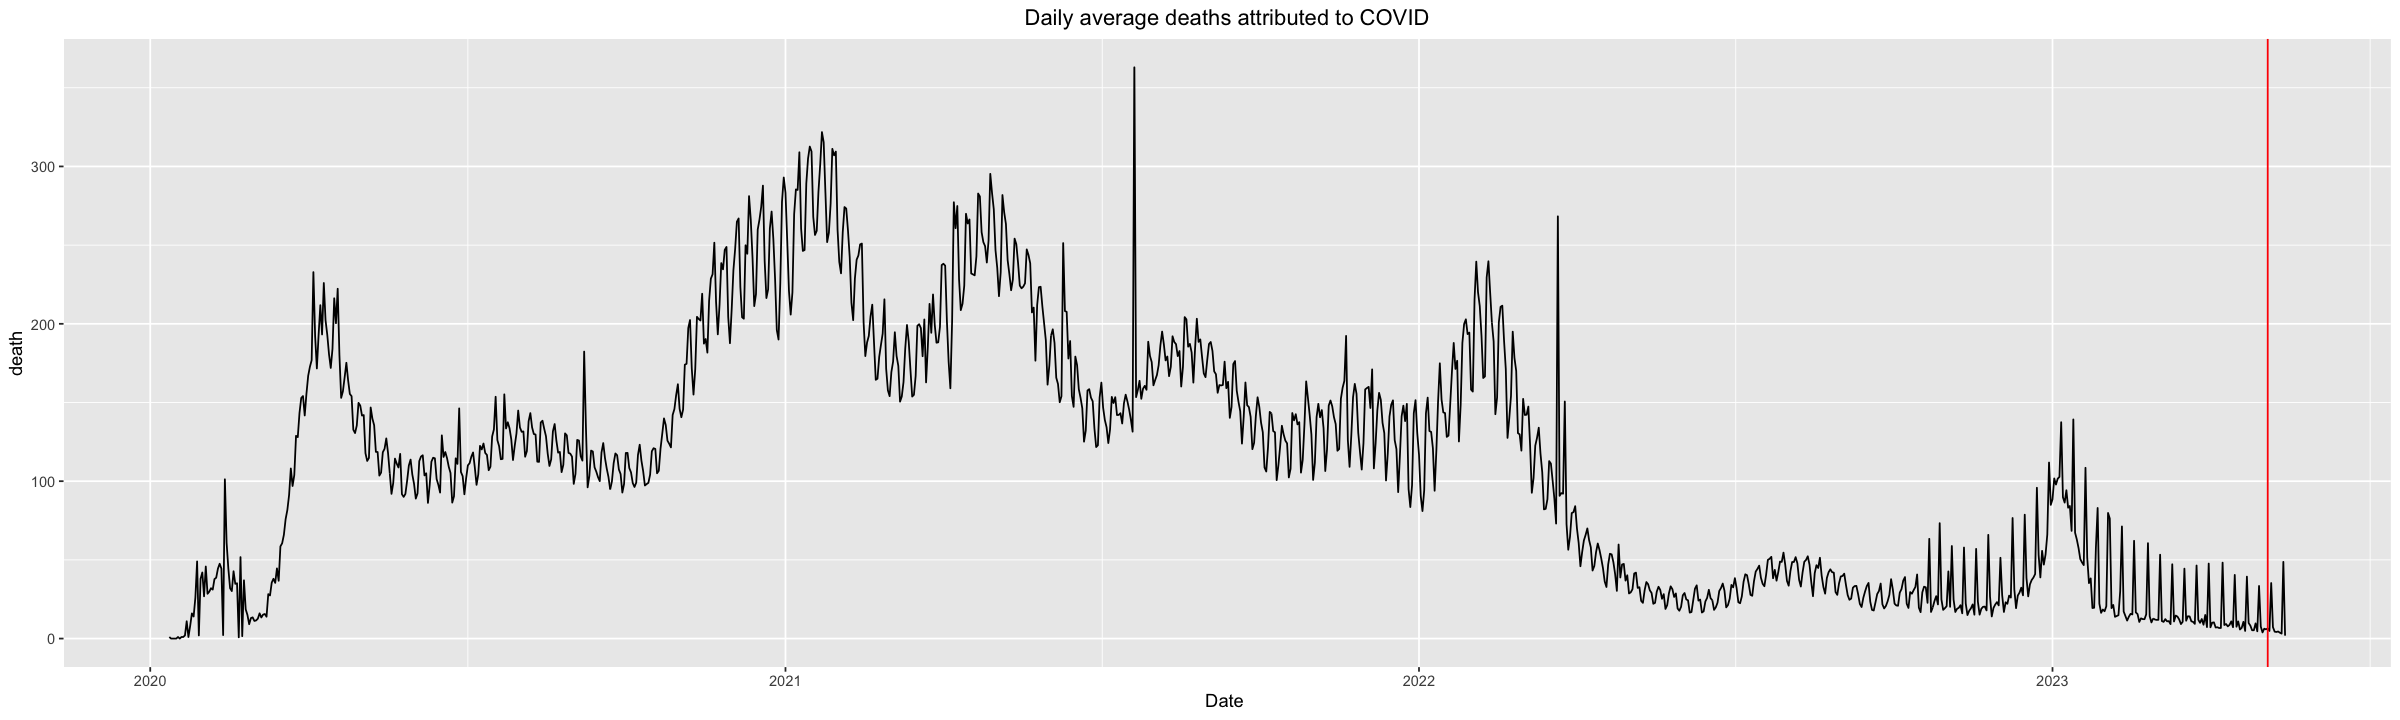

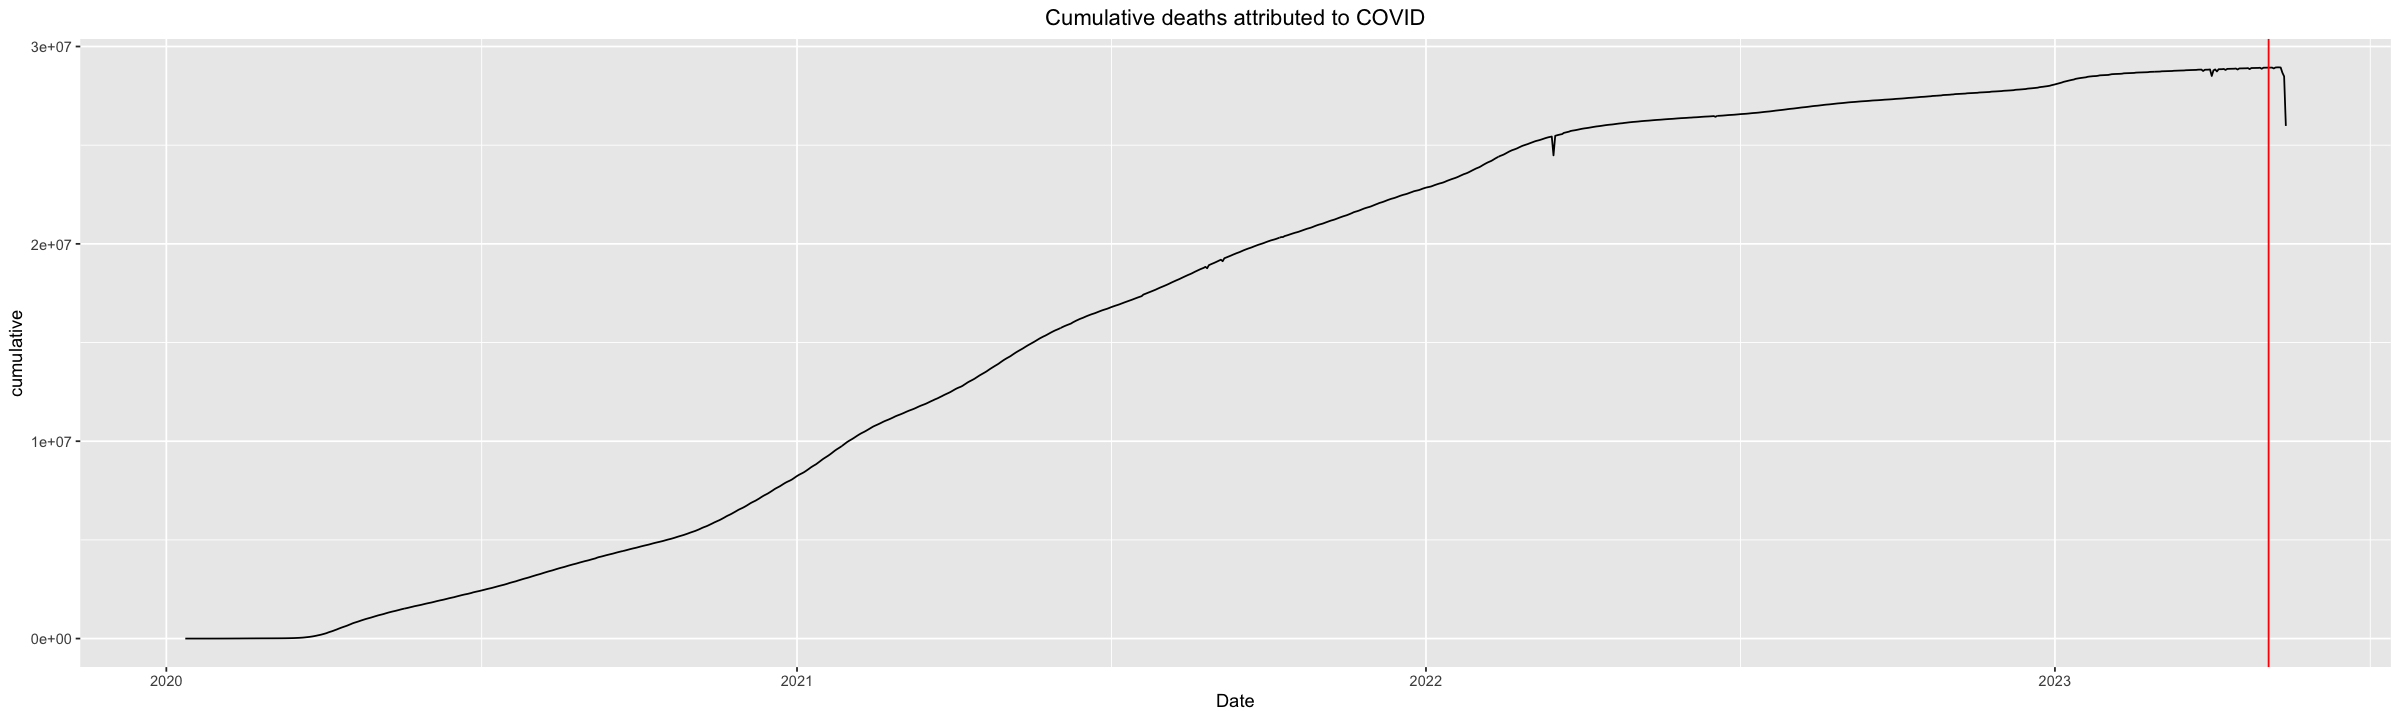

In [333]:
deaths<-data.frame(covid$date,covid$new_deaths,covid$total_deaths)

deaths$covid.date <- as.Date(deaths$covid.date, "%Y-%m-%d") 

deaths<-as_tibble(deaths)


tda<-deaths$covid.date
deaths$week <- (interval(min(tda), tda) %/% weeks(1)) + 1


a<-deaths %>% drop_na() %>% group_by(covid.date)%>%
                    summarise(death = mean(covid.new_deaths),
                             cumulative=sum(covid.total_deaths))
a<-slice(a, 1:(n() - 2)) 


ggplot(data=a,aes(x=covid.date,y=death))+geom_line(aes(y=death))+ geom_vline(xintercept =as.Date('2023-05-05',"%Y-%m-%d"),color='red')+
    ggtitle("Daily average deaths attributed to COVID") +
   theme(plot.title = element_text(hjust = 0.5)) +
   xlab("Date ")
ggplot(data=a,aes(x=covid.date,y=cumulative))+geom_line(aes(y=cumulative))+ geom_vline(xintercept =as.Date('2023-05-05',"%Y-%m-%d"),color='red')+
ggtitle("Cumulative deaths attributed to COVID") +
   theme(plot.title = element_text(hjust = 0.5)) +
   xlab("Date")

**On 2023-05-05 WHO declared the end of the covid pandemic (red line).**

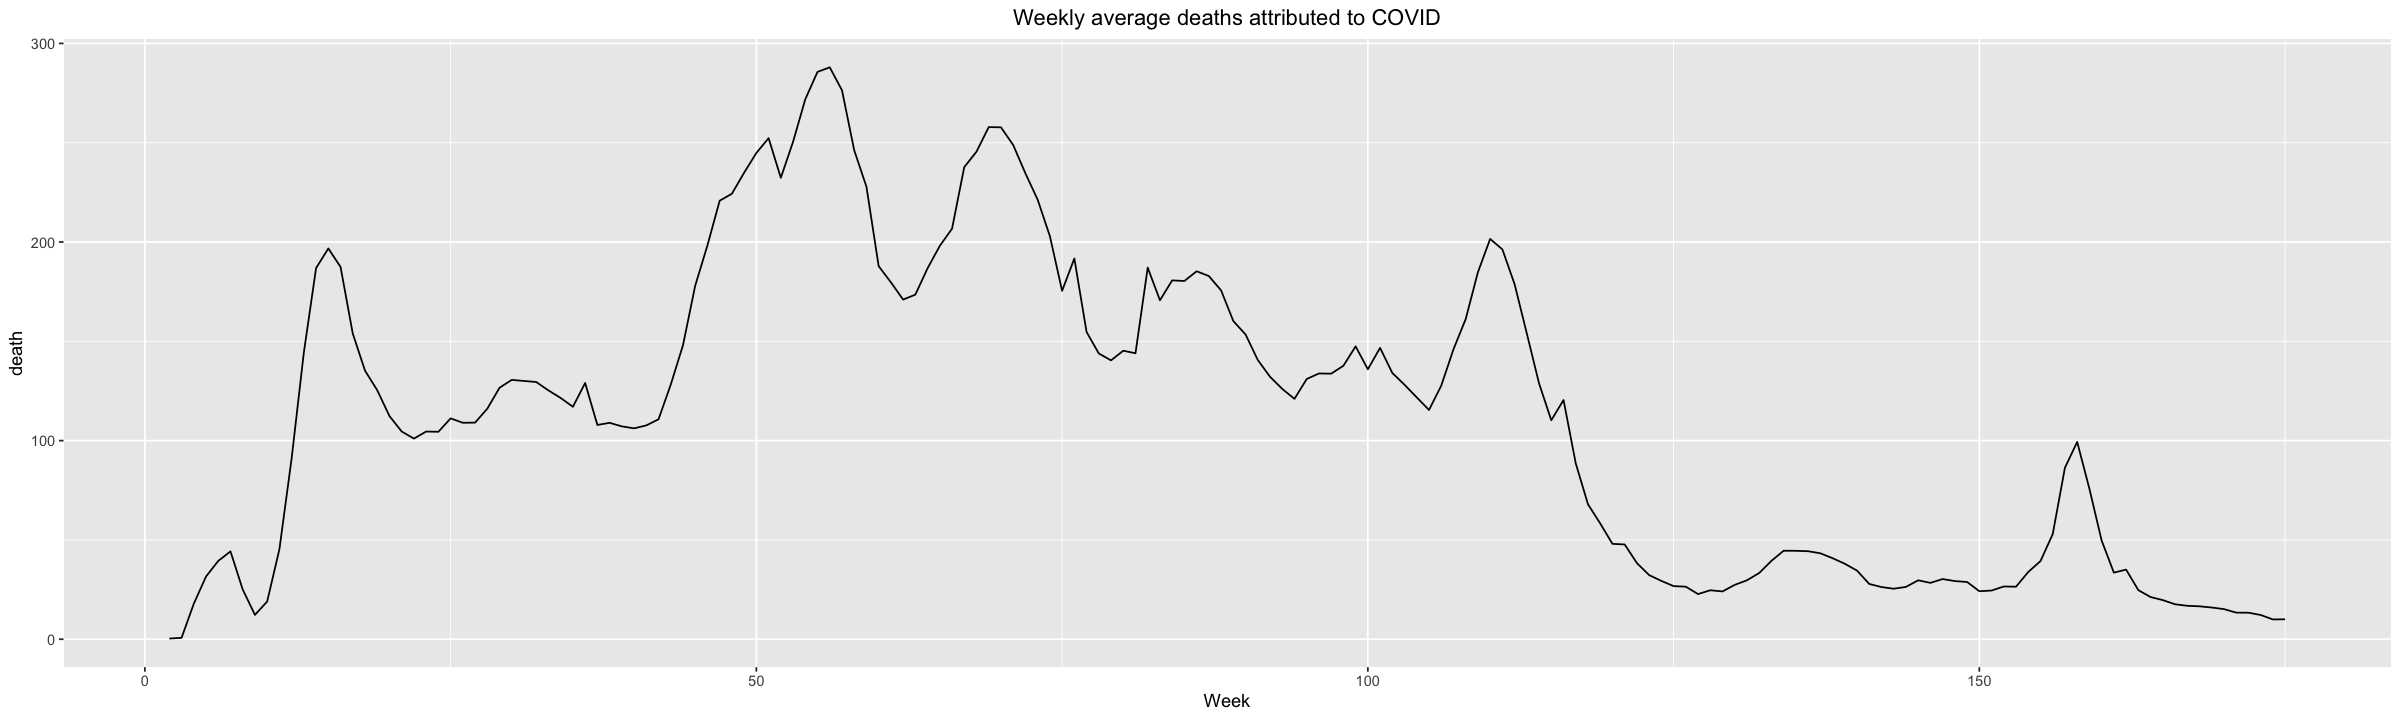

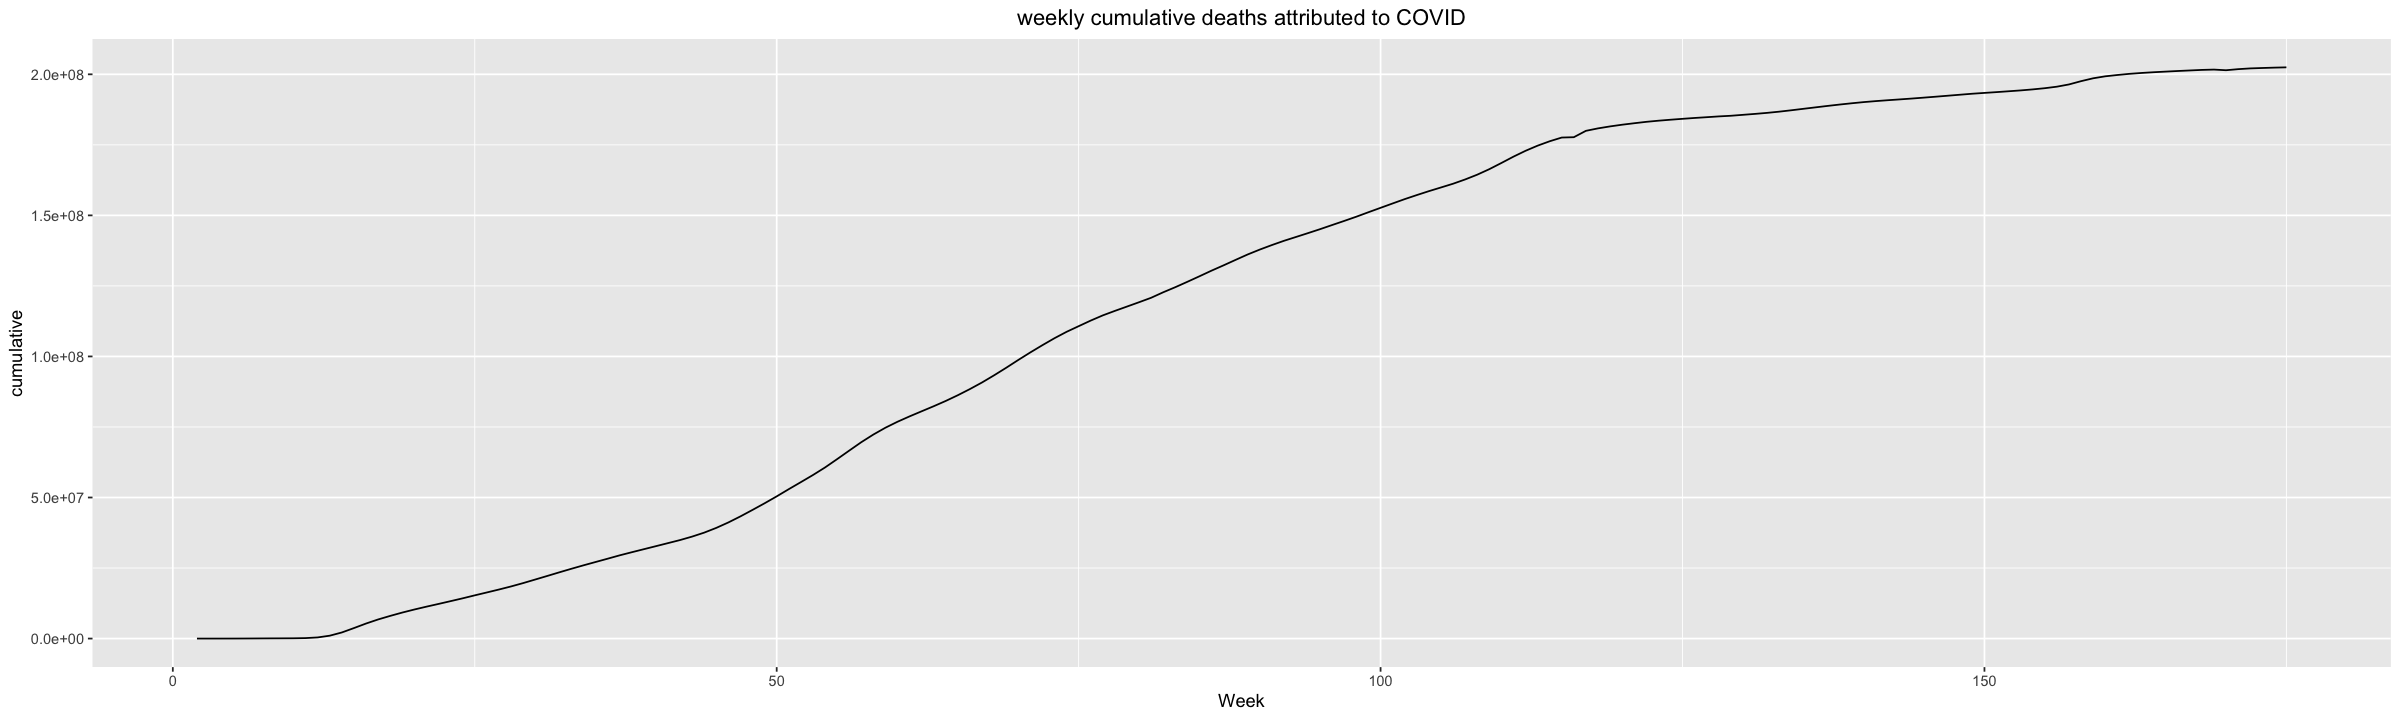

In [334]:
a<-deaths %>% drop_na() %>% group_by(week)%>%
                    summarise(death = mean(covid.new_deaths),
                             cumulative=sum(covid.total_deaths))
a<-slice(a, 1:(n() - 2)) 

ggplot(data=a,aes(x=week,y=death))+geom_line(aes(y=death))+ ggtitle("Weekly average deaths attributed to COVID") +
   theme(plot.title = element_text(hjust = 0.5)) +
   xlab("Week")
ggplot(data=a,aes(x=week,y=cumulative))+geom_line(aes(y=cumulative))+ggtitle("weekly cumulative deaths attributed to COVID") +
   theme(plot.title = element_text(hjust = 0.5)) +
   xlab("Week")

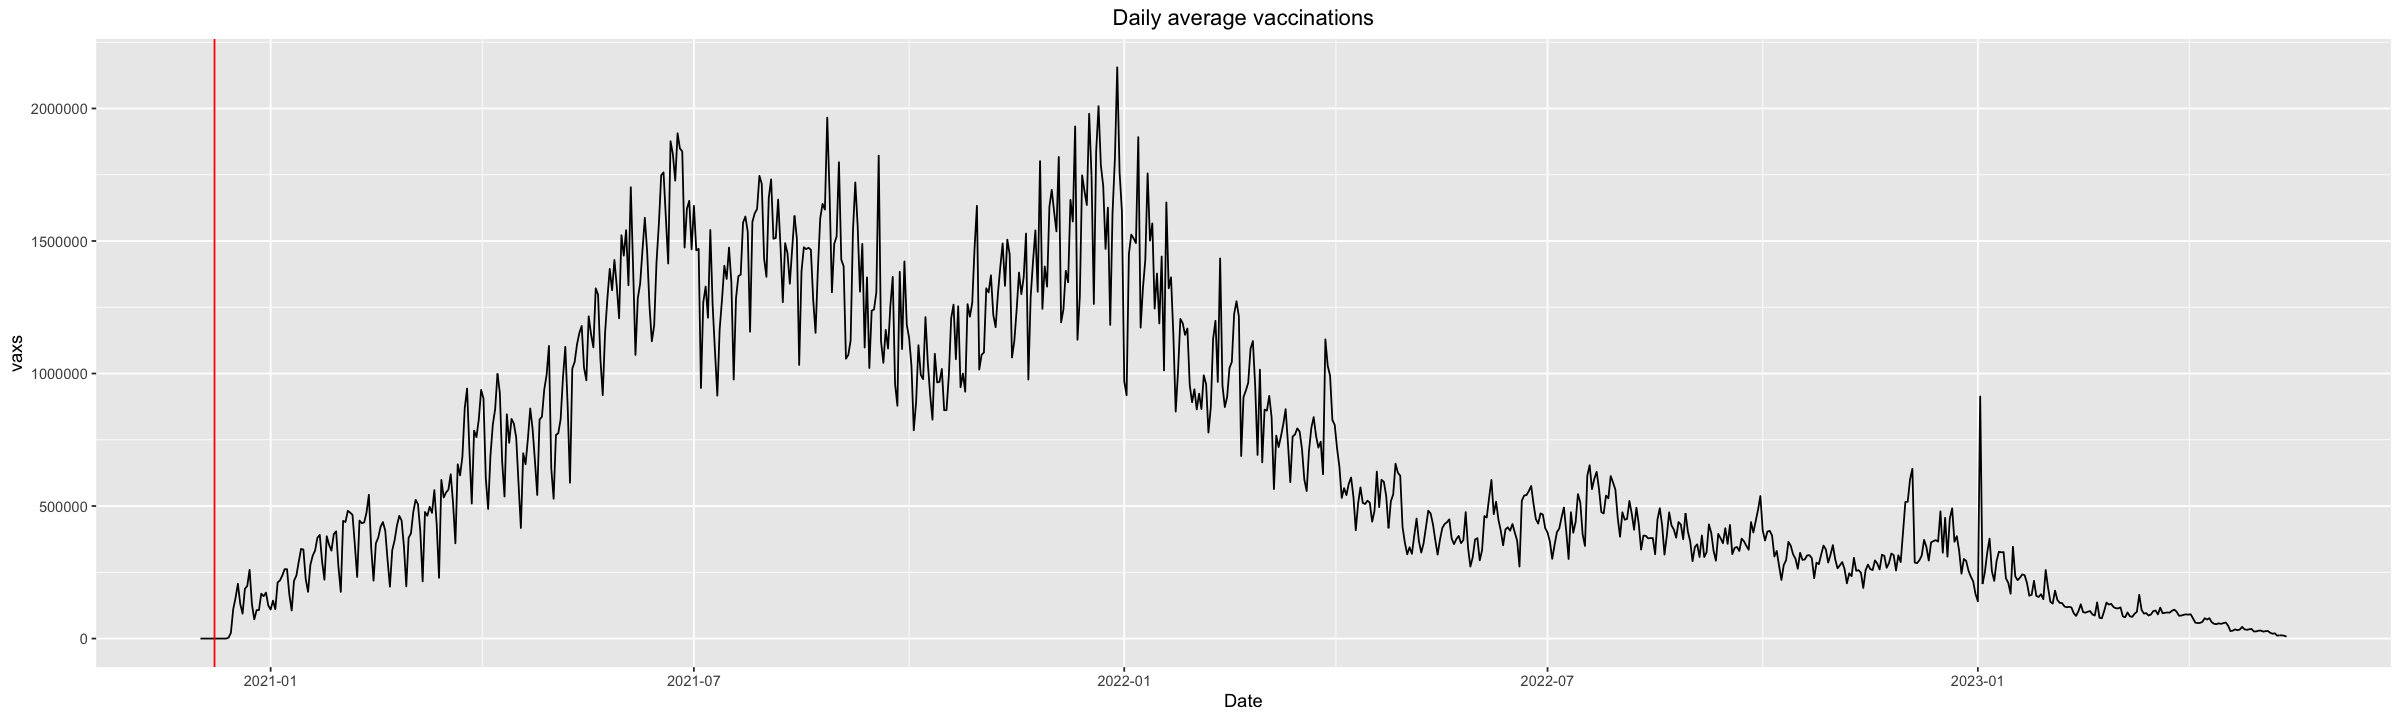

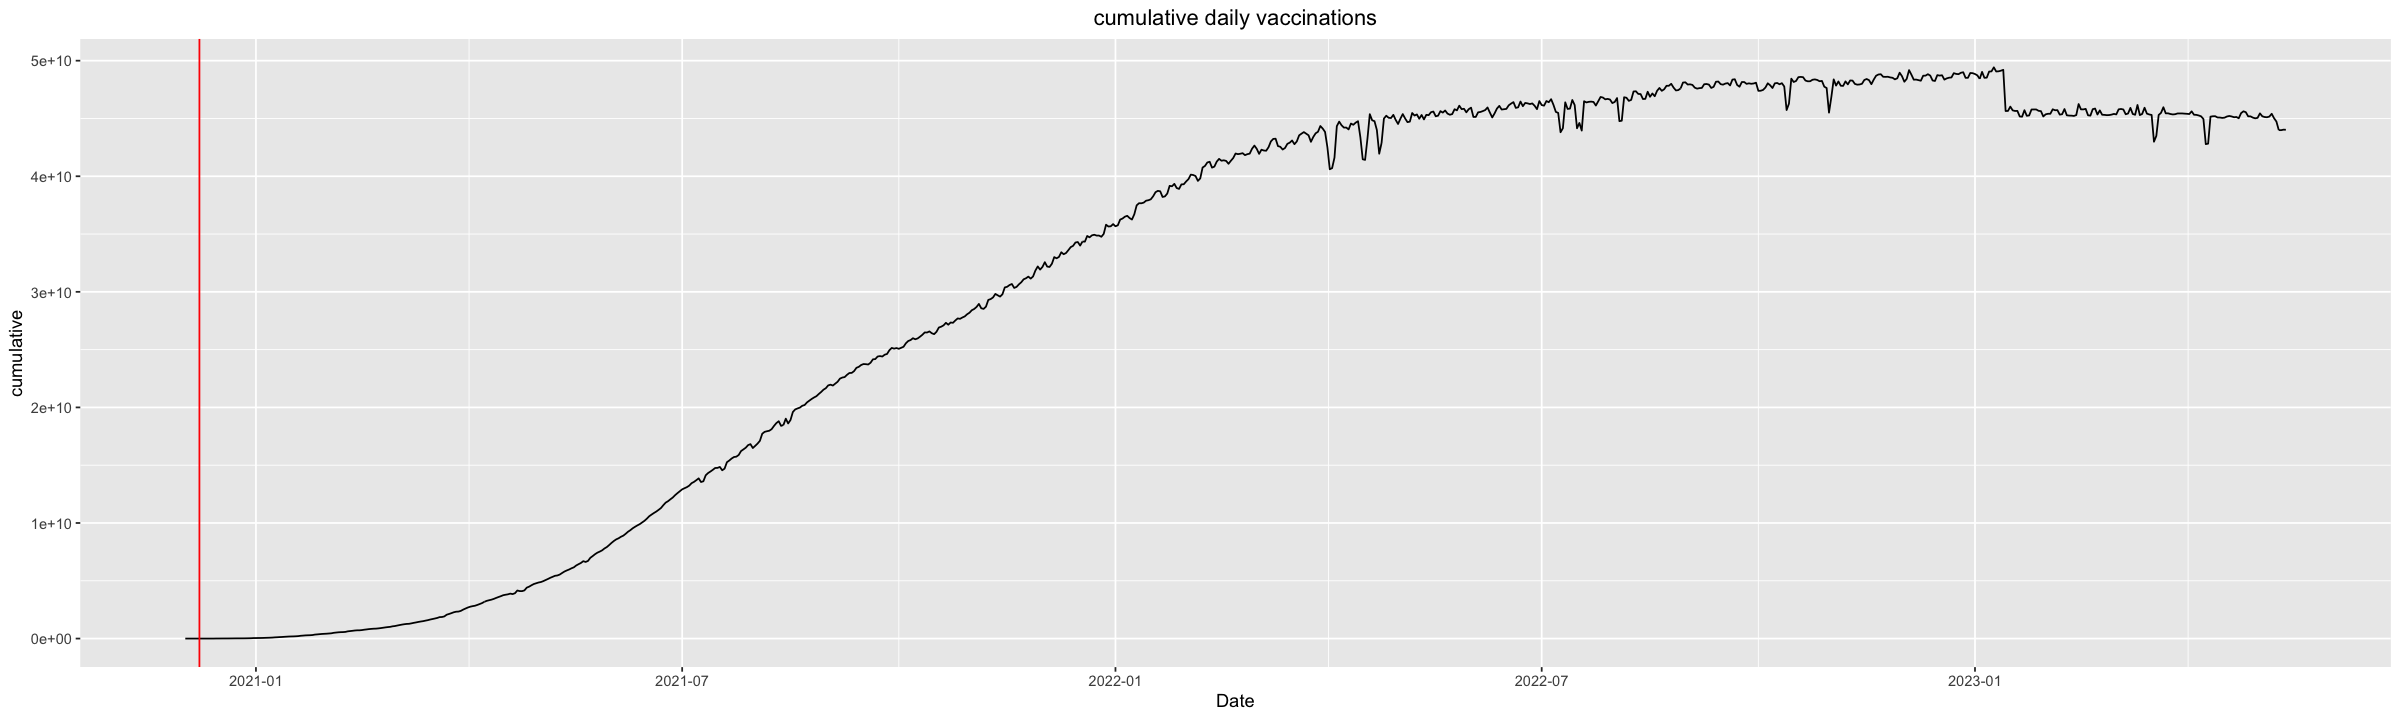

In [335]:
vax<-data.frame(covid$date,covid$new_vaccinations,covid$total_vaccinations)

vax$covid.date <- as.Date(vax$covid.date, "%Y-%m-%d") 

vax<-as_tibble(vax)


tda<-vax$covid.date
vax$week <- (interval(min(tda), tda) %/% weeks(1)) + 1




a<-vax %>% drop_na() %>% group_by(covid.date)%>%
                    summarise(vaxs = mean(covid.new_vaccinations),
                             cumulative=sum(covid.total_vaccinations))

a<-slice(a, 1:(n() - 6)) #discarded last six rows



ggplot(data=a,aes(x=covid.date,y=vaxs))+geom_line(aes(y=vaxs))+ geom_vline(xintercept =as.Date('2020-12-8',"%Y-%m-%d"),color='red')+
 ggtitle("Daily average vaccinations") +
   theme(plot.title = element_text(hjust = 0.5)) +
   xlab("Date")

ggplot(data=a,aes(x=covid.date,y=cumulative))+geom_line(aes(y=cumulative))+geom_vline(xintercept =as.Date('2020-12-8',"%Y-%m-%d"),color='red')+
 ggtitle("cumulative daily vaccinations") +
   theme(plot.title = element_text(hjust = 0.5)) +
   xlab("Date")

**On 2020-12-8 (red line) the first person had received the vaccine.**

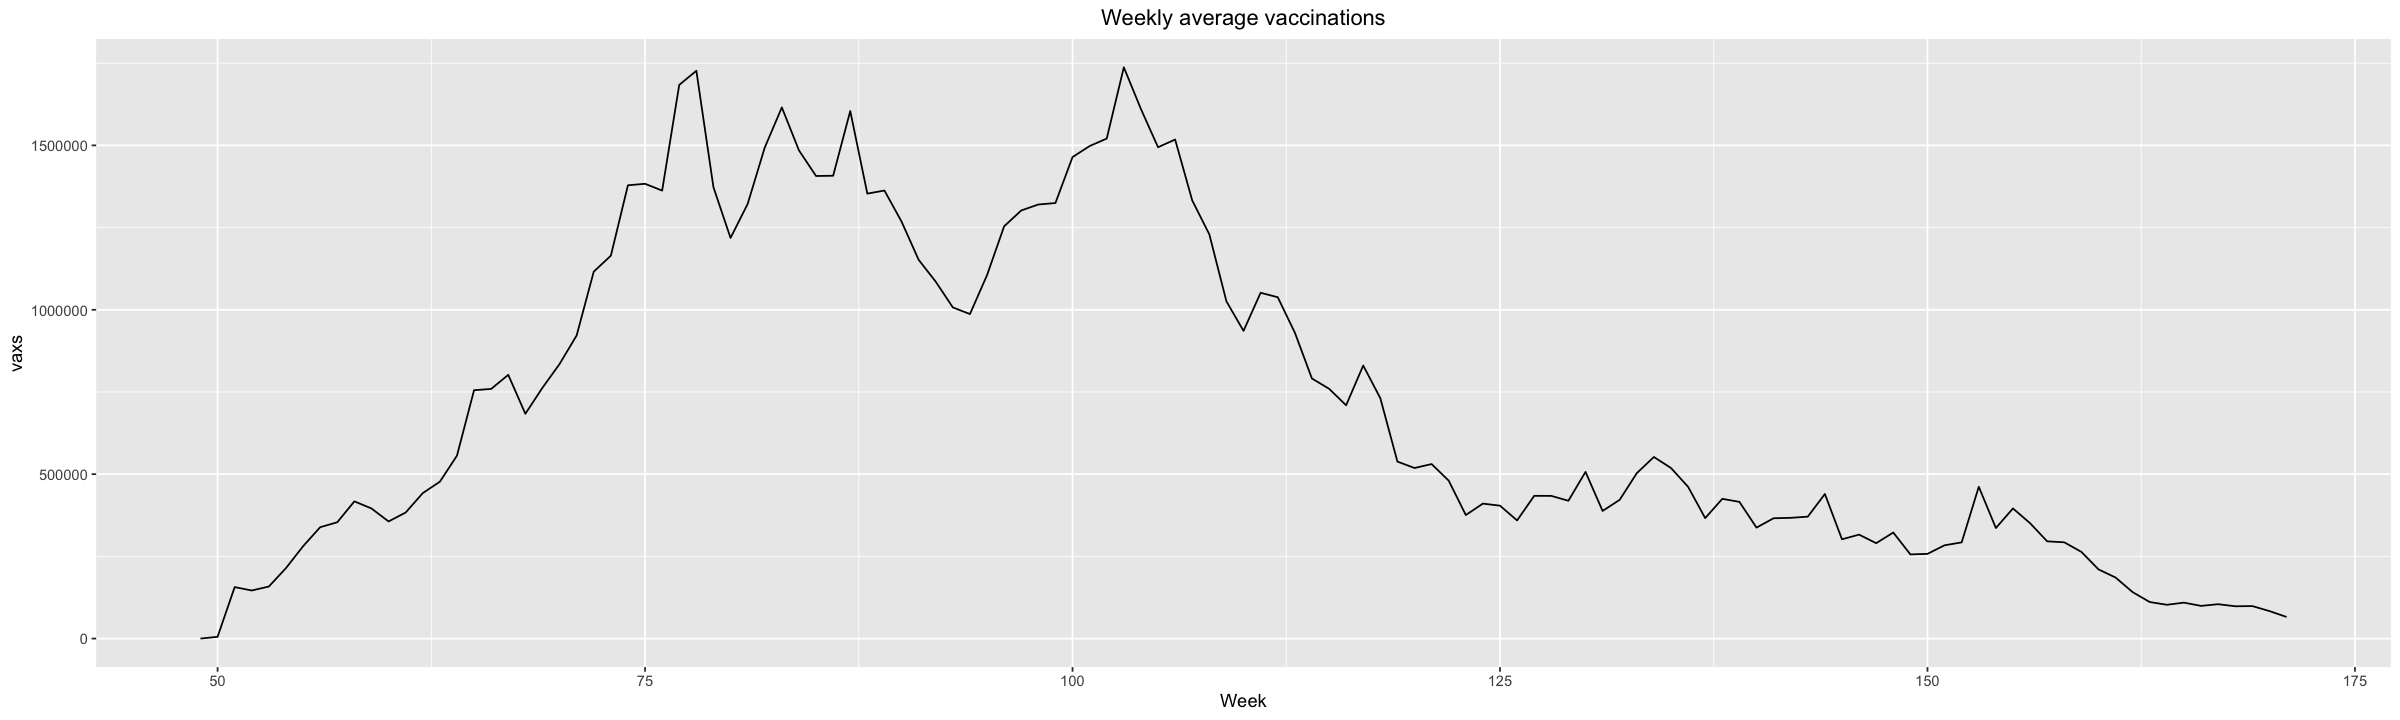

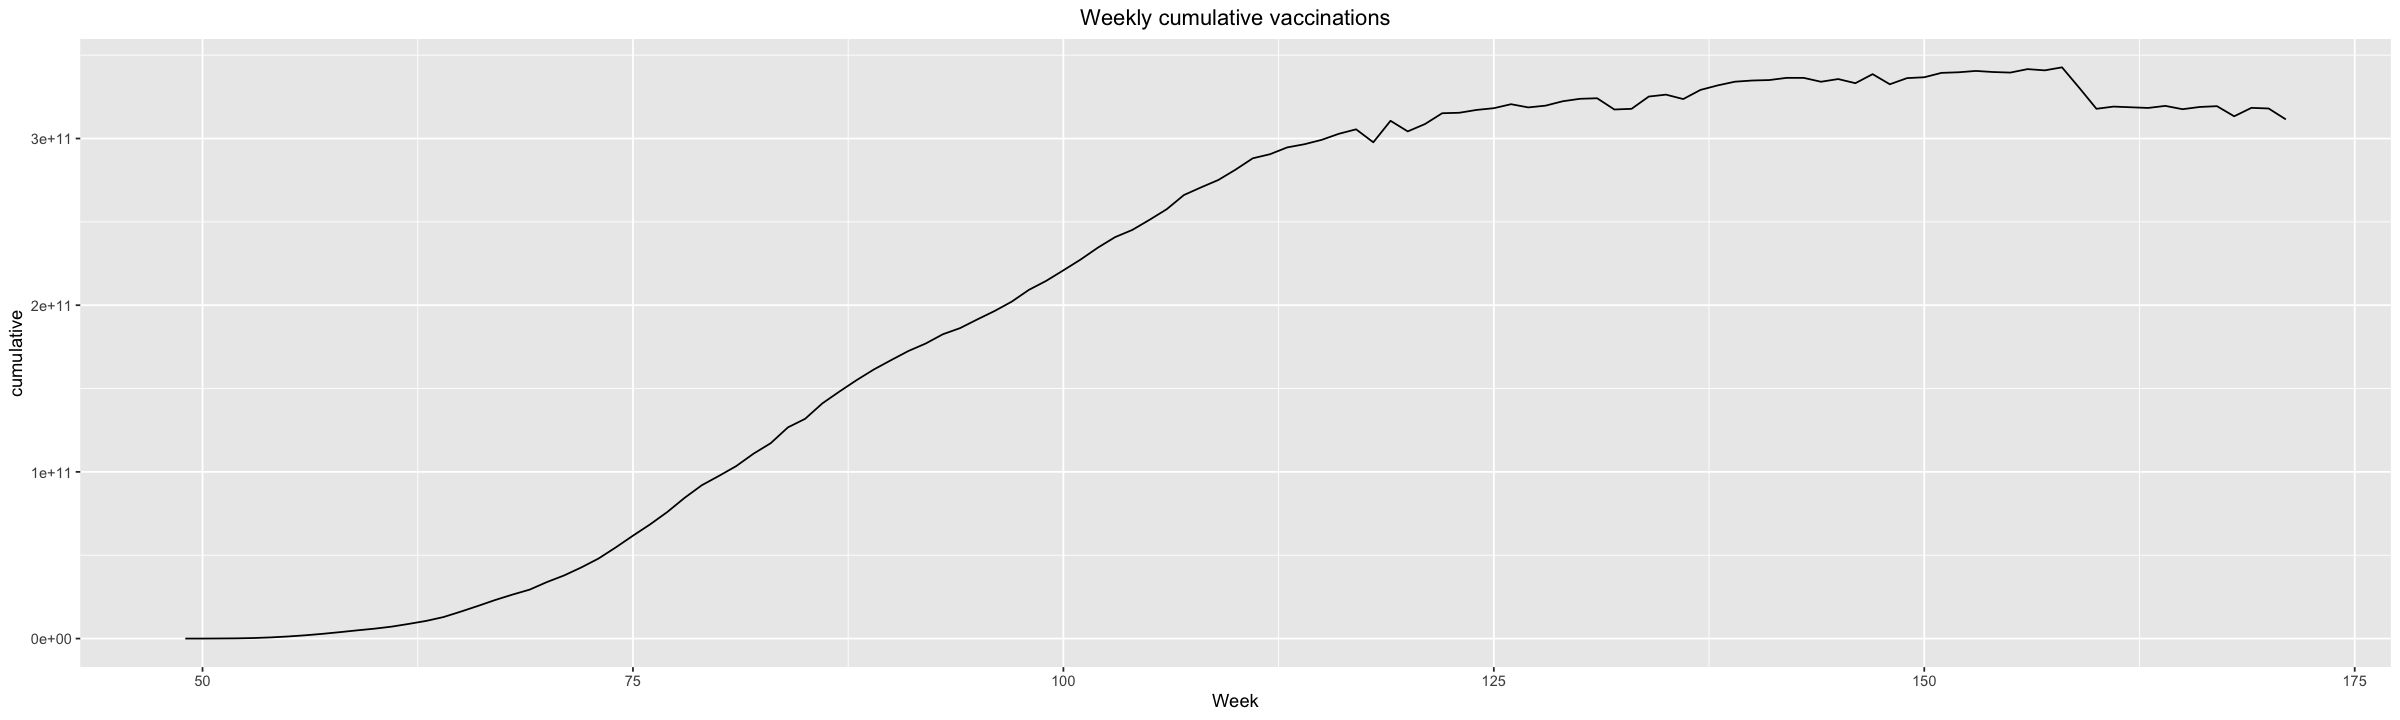

In [336]:
a<-vax %>% drop_na() %>% group_by(week)%>%
                    summarise(vaxs = mean(covid.new_vaccinations),
                             cumulative=sum(covid.total_vaccinations))
a<-slice(a, 1:(n() - 6)) #removing last six weeks for plotting purposes, data is not updated correctly and cumulative drops to zero


ggplot(data=a,aes(x=week,y=vaxs))+geom_line(aes(y=vaxs))+ ggtitle("Weekly average vaccinations") +
   theme(plot.title = element_text(hjust = 0.5)) +
   xlab("Week")

ggplot(data=a,aes(x=week,y=cumulative))+geom_line(aes(y=cumulative))+ ggtitle("Weekly cumulative vaccinations") +
   theme(plot.title = element_text(hjust = 0.5)) +
   xlab("Week")